In [40]:
import sys
sys.path.append("/home/laviniad/projects/religion_in_congress")

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from data import congress_utils

tqdm.pandas()

In [42]:
##### INSTEAD: load "/data/laviniad/congress_errata/best_claude_labels_on_references.csv"

refs = pd.read_csv("/data/laviniad/congress_errata/best_claude_labels_on_references.csv")

In [43]:
# load congress df
cr_path = "/data/corpora/congressional-record/"
full_cr_df = congress_utils.load_full_df_from_raw(cr_path)

On file 0


100%|██████████| 106493/106493 [00:01<00:00, 104043.44it/s]


On file 1


100%|██████████| 190933/190933 [00:01<00:00, 102612.49it/s]


On file 2


100%|██████████| 94162/94162 [00:00<00:00, 107666.61it/s]


On file 3


100%|██████████| 207487/207487 [00:02<00:00, 101155.34it/s]


On file 4


100%|██████████| 183503/183503 [00:01<00:00, 105292.52it/s]


On file 5


100%|██████████| 130265/130265 [00:01<00:00, 108775.90it/s]


On file 6


100%|██████████| 197548/197548 [00:01<00:00, 103761.84it/s]


On file 7
On file 8
On file 9


100%|██████████| 139281/139281 [00:01<00:00, 110946.01it/s]


On file 10


100%|██████████| 127268/127268 [00:01<00:00, 109719.81it/s]


On file 11
On file 12


100%|██████████| 179989/179989 [00:01<00:00, 106090.42it/s]


On file 13
On file 14


100%|██████████| 271528/271528 [00:01<00:00, 144411.19it/s]


On file 15


100%|██████████| 48007/48007 [00:00<00:00, 194884.05it/s]


On file 16


100%|██████████| 210379/210379 [00:01<00:00, 170352.05it/s]


On file 17


100%|██████████| 196111/196111 [00:01<00:00, 161369.45it/s]


On file 18


100%|██████████| 122717/122717 [00:00<00:00, 180177.02it/s]


In [44]:
full_cr_df['speech_id'] = full_cr_df.index.to_series()

In [45]:
refs.columns

Index(['llm_response', 'label_llm', 'verse_llm', 'congress_idx', 'text',
       'most_similar_verse', 'shared_ngrams', 'verse_baseline',
       'cosine_similarity'],
      dtype='object')

In [46]:
def extract_speech_id(x):
    if isinstance(x, int):
        return x
    elif isinstance(x, str) and '(' in x:
        x = x.split('(')[1]
        x = x.split(')')[0]
        return int(x)
    elif isinstance(x, str):
        return int(x)
    else:
        return None

In [47]:
refs['speech_id'] = refs['congress_idx'].apply(lambda x: extract_speech_id(x))

In [48]:
# merge refs with information from cr_df

# namely, bio_id; speaker; date; chamber; full speech text

# to be clear: we are merging on 'speech_id' from refs and the index of cr_df

# first, we need to create a 'speech_id' column in cr_df

full_cr_df['speech_id'] = full_cr_df.index.to_series()

merged = pd.merge(refs, full_cr_df, on='speech_id', how='inner')
assert(len(merged) == len(refs))

In [49]:
#### REMOVE MERGED WHERE LLM_LABEL IS 0
## NOT DOING THIS due to claude's poor discernment

#merged = merged[merged['label_llm'] != 0]

In [50]:
print(len(merged))

1555


In [51]:
from data.congress_utils import induce_party_and_state, induce_gender

merged = induce_party_and_state(merged)
merged = induce_gender(merged)

In [52]:
merged['speaker'].head()

0    Mr. GRASSLEY
1       Mr. KAINE
2      Mr. DAINES
3     Mr. CLYBURN
4      Mr. FLORES
Name: speaker, dtype: object

In [53]:
merged.to_csv("/data/laviniad/congress_errata/merged_refs_llm.csv", index=False)

In [54]:
import pandas as pd
merged = pd.read_csv("/data/laviniad/congress_errata/merged_refs_llm.csv")

In [55]:
len(merged['speech_id'].unique())

898

In [56]:
# number of unique speakers -- bio_id
len(merged['bio_id'].unique())


355

In [57]:
merged.columns

Index(['llm_response', 'label_llm', 'verse_llm', 'congress_idx', 'text_x',
       'most_similar_verse', 'shared_ngrams', 'verse_baseline',
       'cosine_similarity', 'speech_id', 'bio_id', 'congress_num', 'year',
       'date', 'chamber', 'speaker', 'text_y', 'month_code', 'month', 'party',
       'state', 'gender'],
      dtype='object')

In [58]:
claude_rejections = merged[merged['label_llm'] == 0]
claude_rejections['verse_baseline'] = claude_rejections['verse_baseline'].apply(lambda x: x.removesuffix('\'').removeprefix('b\''))
claude_rejections['most_similar_verse'] = claude_rejections['most_similar_verse'].apply(lambda x: x.removesuffix('\'').removeprefix('b\''))
claude_rejections = claude_rejections[['text_x', 'verse_baseline', 'most_similar_verse', 'cosine_similarity', 'shared_ngrams']]
claude_rejections = claude_rejections.rename(columns={'text_x': 'text'})
#laude_rejections = claude_rejections.drop_duplicates(subset=['speech_id', 'text'], keep='first')
claude_rejections = claude_rejections.reset_index(drop=True)
claude_rejections.to_csv("/data/laviniad/congress_errata/claude_rejections.csv", index=False)

/tmp/ipykernel_717930/671216669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude_rejections['verse_baseline'] = claude_rejections['verse_baseline'].apply(lambda x: x.removesuffix('\'').removeprefix('b\''))
/tmp/ipykernel_717930/671216669.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  claude_rejections['most_similar_verse'] = claude_rejections['most_similar_verse'].apply(lambda x: x.removesuffix('\'').removeprefix('b\''))


In [59]:
print("Percentage of speeches with a reference: ", 100 * len(merged['speech_id'].unique()) / len(full_cr_df['speech_id'].unique()))

Percentage of speeches with a reference:  0.03732846262020035


In [60]:
def capitalize_first_letter(s):
    return ' '.join([word.capitalize() for word in s.split()])

merged['verse_llm'] = merged['verse_llm'].apply(capitalize_first_letter)

In [61]:
merged.columns

Index(['llm_response', 'label_llm', 'verse_llm', 'congress_idx', 'text_x',
       'most_similar_verse', 'shared_ngrams', 'verse_baseline',
       'cosine_similarity', 'speech_id', 'bio_id', 'congress_num', 'year',
       'date', 'chamber', 'speaker', 'text_y', 'month_code', 'month', 'party',
       'state', 'gender'],
      dtype='object')

In [62]:
def remove_formatting(s):
    return s.removesuffix('\'').removeprefix('b\'')

merged['verse_baseline'] = merged['verse_baseline'].apply(remove_formatting)

In [63]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')

/tmp/ipykernel_717930/3577186240.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered['year'] = merged_filtered['year'].astype(int)


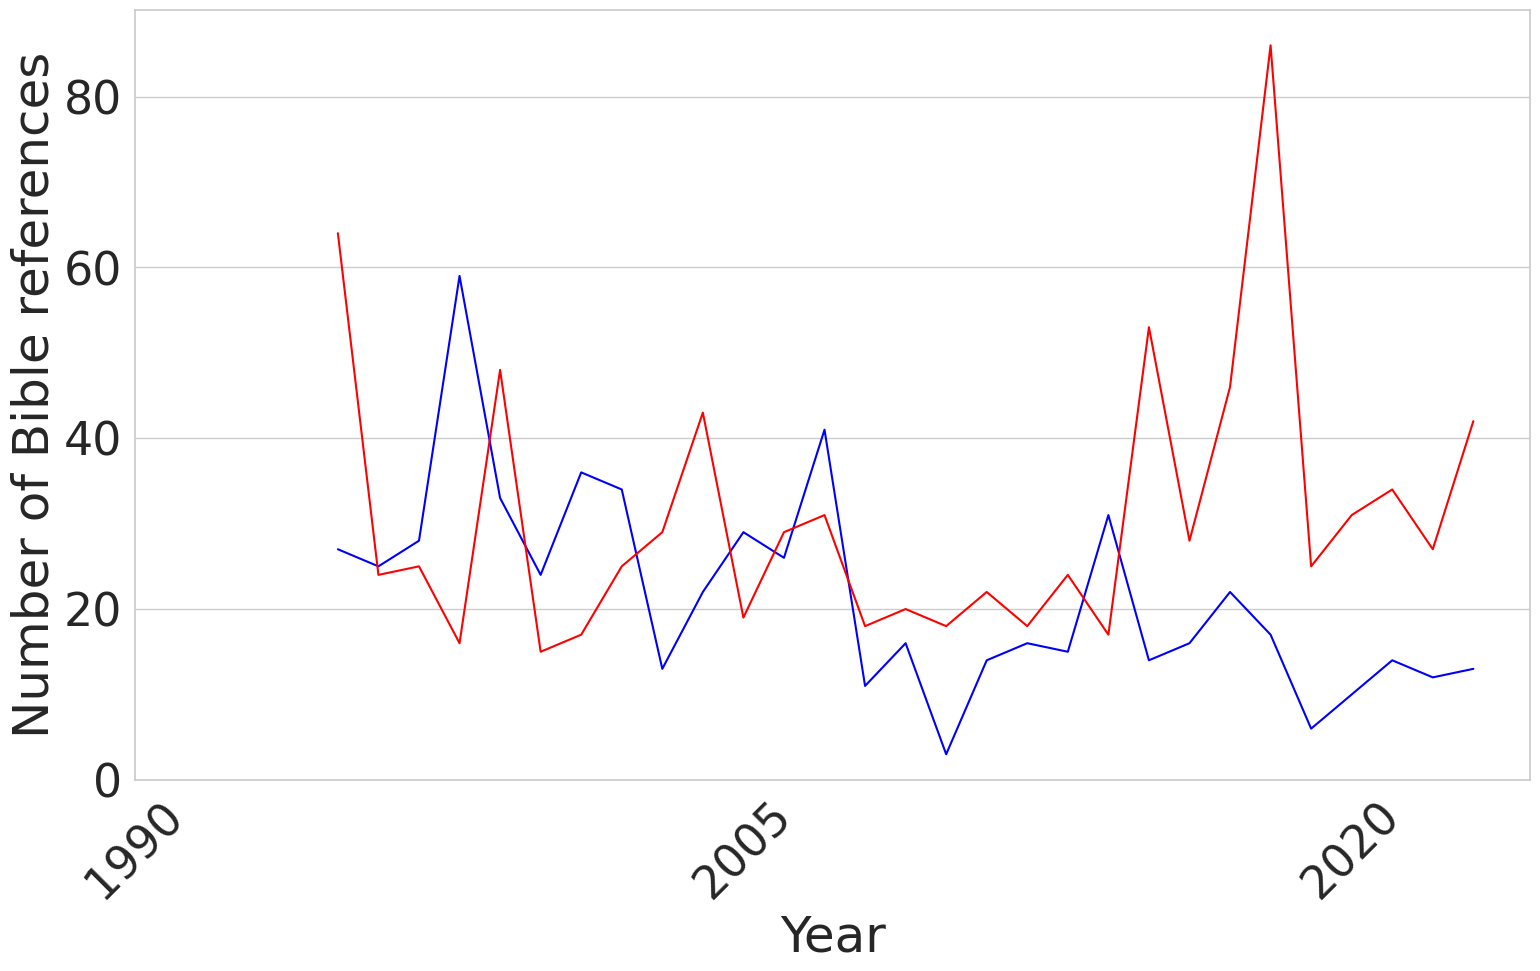

In [64]:
# plot number of references per year wrt party

#palette = {'Democrat': 'blue', 'Republican': 'red'}
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')
accepted_parties = ['Democrat', 'Republican']

# filter out rows where party is not in palette
merged_filtered = merged[merged['party'].isin(accepted_parties)]
merged_filtered['year'] = merged_filtered['year'].astype(int)

# aggregate by year and party for counts
fig, ax = plt.subplots(figsize=(18, 10))
count_df = merged_filtered.groupby(['year', 'party']).size().reset_index(name='count')
sns.lineplot(x='year', y='count', hue='party', data=count_df, palette=palette, ax=ax)

# rotate x and only show some
plt.xlabel("Year")
plt.ylabel("Number of Bible references")
plt.grid(axis='x')
ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=45)
# turn off vertical grid lines
plt.ylim(0, None)

ax.get_legend().remove()
#plt.legend(title='Party', loc='upper left', labels=['Democrat', 'Republican'])
#ax.set_xticks(ax.get_xticks()[::2])
plt.savefig("/home/laviniad/projects/religion_in_congress/plots/br_count_over_time.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()

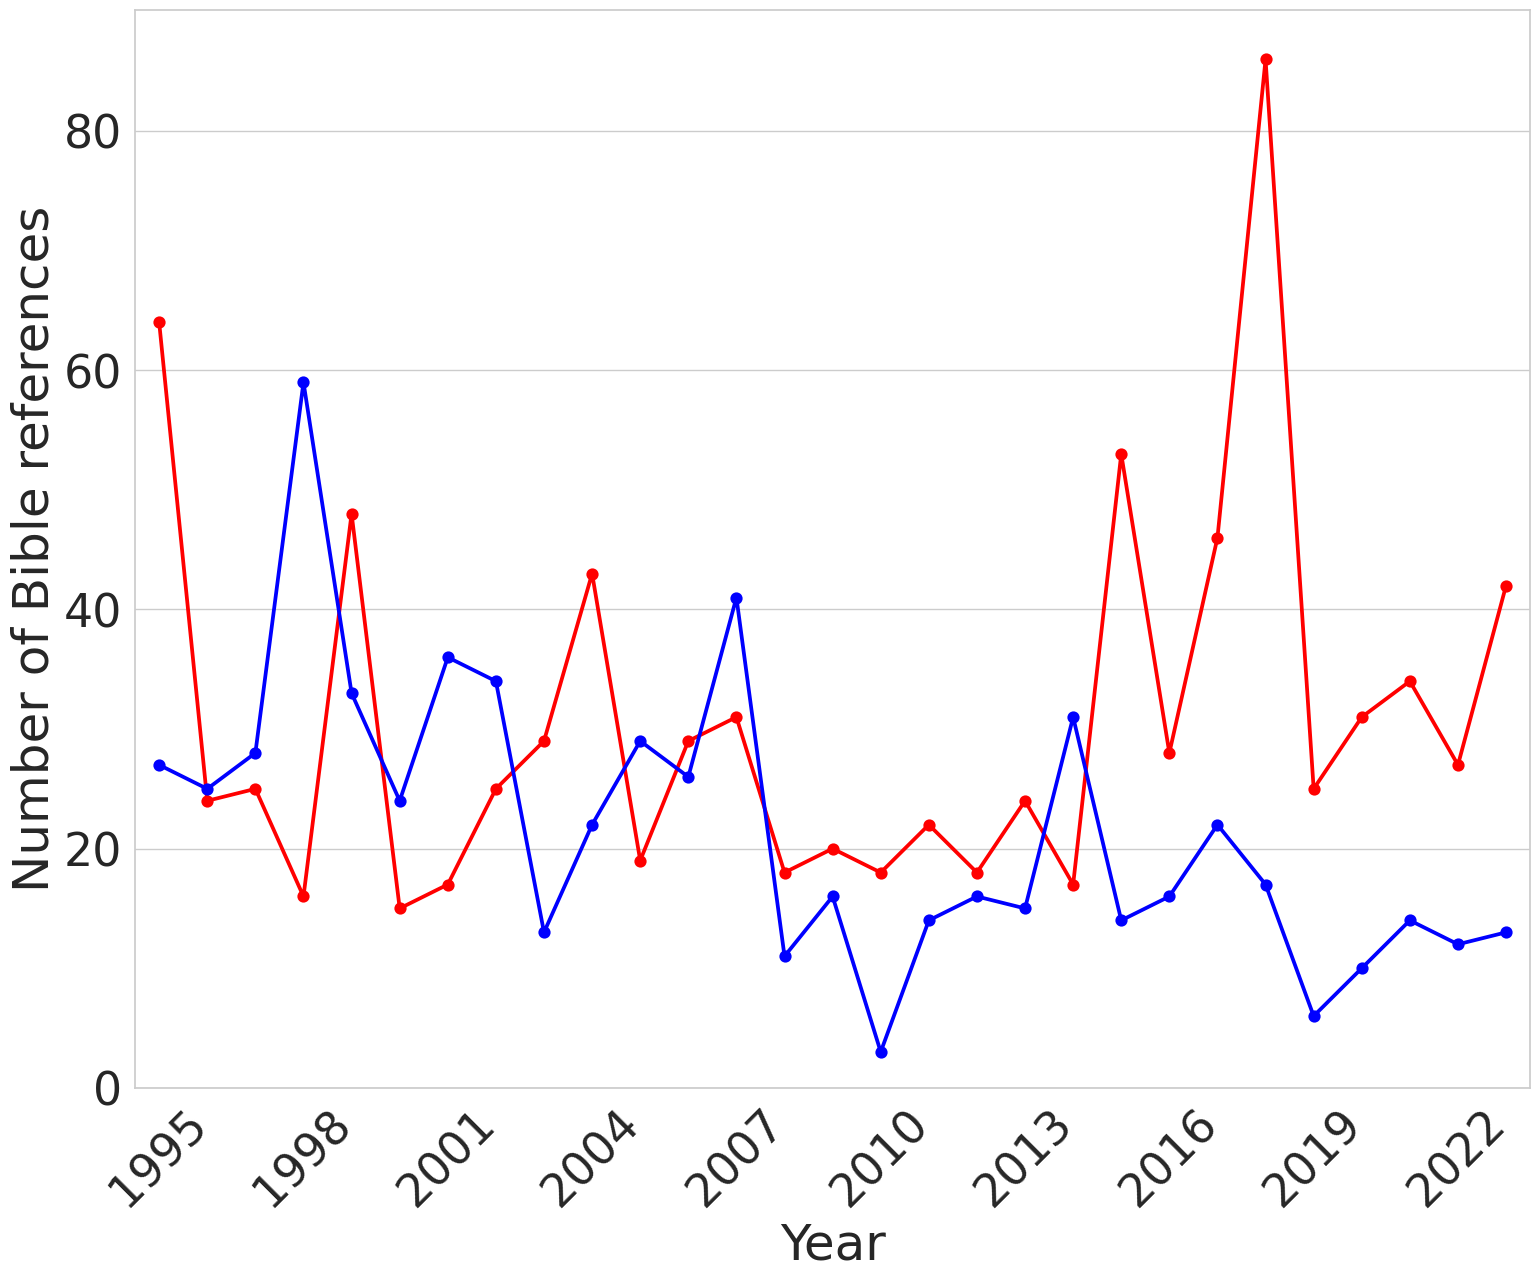

In [65]:
#plt.rcParams['font.weight'] = 'bold'
fig, ax = plt.subplots(figsize=(18, 14))

plt.rcParams['font.weight'] = 'normal'
sns.pointplot(data=count_df, y='count', x='year', hue='party', hue_order=['Republican', 'Democrat'], 
              palette=palette)
#sns.lineplot(data=res, y='lexical', x='year', color='black', ci=None)
#sns.pointplot(y=pres_num[:,3], x=pres_num[:,0], hue=pres_num[:,4])#, linestyle='none', errorbar=None)
#years = sorted(set(df['year']))
#ticks = list(range(min(years), max(years) + 1, 5))
#plt.xticks(ticks)

#plt.xlim(1995, 2023)
plt.ylim(0, None)
ax.set_xticks(ax.get_xticks()[::3])
plt.xticks(rotation=45)

plt.ylabel('Number of Bible references')
plt.xlabel('Year')
ax.get_legend().remove()
#plt.legend(title='Party', bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0)
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/br_count_over_time.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_717930/1273338672.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered['year'] = merged_filtered['year'].astype(int)


<Figure size 2200x800 with 0 Axes>

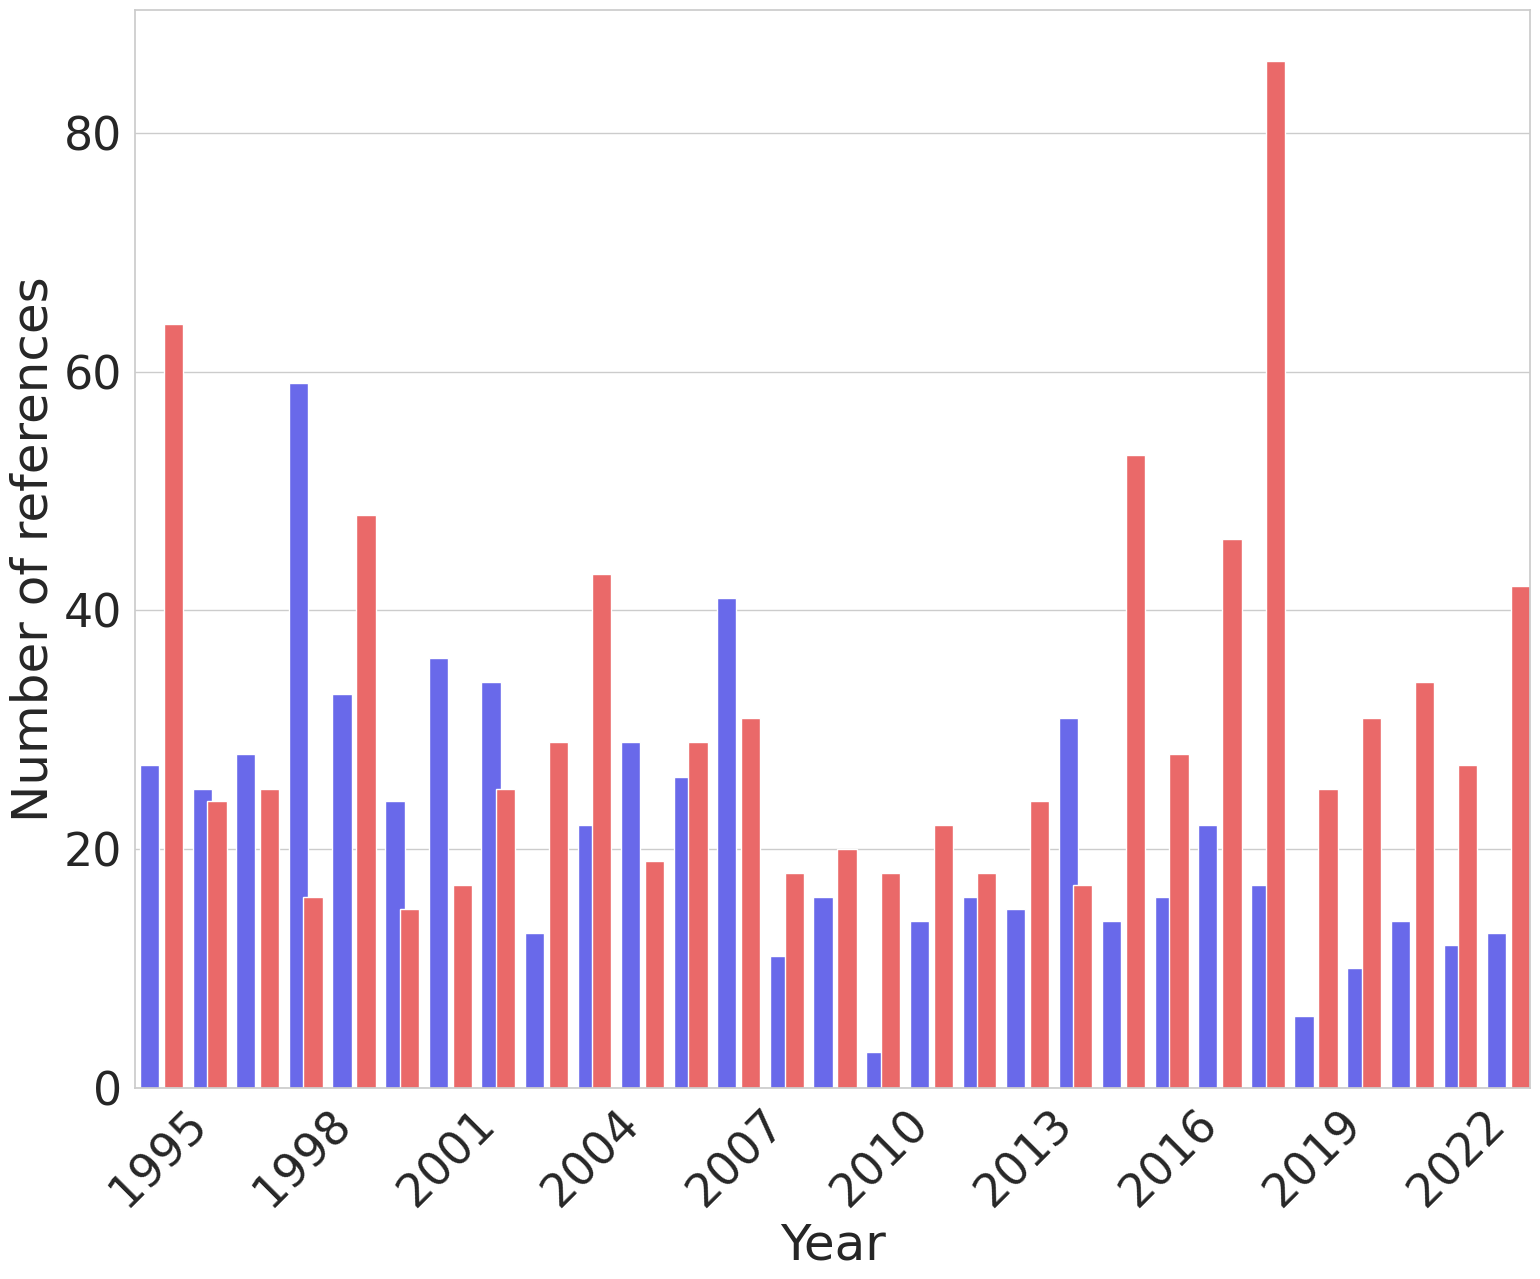

In [66]:
palette = {'Democrat': '#5454FF', 'Republican': '#FF5454'}

plt.figure(figsize=(22, 8))
fig, ax = plt.subplots()

# Ensure 'year' is integer
merged_filtered['year'] = merged_filtered['year'].astype(int)

# Create the countplot
cax = sns.countplot(x='year', hue='party', data=merged_filtered, palette=palette, width=0.8)

# Reduce bar width and add spacing
bar_width = 0.4  # Smaller bar width
for bar in cax.patches:
    bar.set_width(bar_width)

# Adjust bar positions for better spacing
# Calculate bar positions and add spacing
spacing = 0.1  # Adjust spacing between bars
xticks = [bar.get_x() for bar in cax.patches]
num_categories = len(palette)
for i, bar in enumerate(cax.patches):
    new_x = bar.get_x() + (i % num_categories) * spacing
    bar.set_x(new_x)

# Rotate x-axis labels and adjust ticks
plt.xlabel("Year")
plt.ylabel("Number of references")
plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::3])

# Remove legend (optional)
ax.get_legend().remove()

# Save the plot
plt.savefig(
    "/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/num_brs_per_year_party.pdf",
    bbox_inches="tight",
    format="pdf",
    dpi=300,
)
plt.show()


In [67]:
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/num_brs_per_year_party.pdf")

<Figure size 1800x1400 with 0 Axes>

In [68]:
print("The correlation between year and total number of references:")
# count refs for each year
year_counts = merged.groupby('year').size()
year_counts = year_counts.reset_index()

year_counts.columns = ['year', 'count']
year_counts['year'] = year_counts['year'].astype(int)
year_counts['year'] = year_counts['year'] - 1995

# correlation
correlation = year_counts['year'].corr(year_counts['count'])
print(correlation)
# is it significant
from scipy.stats import pearsonr
p = pearsonr(year_counts['year'], year_counts['count'])
print(p)

The correlation between year and total number of references:
-0.23579477266383347
PearsonRResult(statistic=np.float64(-0.23579477266383353), pvalue=np.float64(0.21817605943890875))


In [69]:
print("Democratic references' correlation with time and number of references:")
dem_refs = merged[merged['party'] == 'Democrat']
dem_year_counts = dem_refs.groupby('year').size()
dem_year_counts = dem_year_counts.reset_index()
dem_year_counts.columns = ['year', 'count']
dem_year_counts['year'] = dem_year_counts['year'].astype(int) - 1995

correlation = pearsonr(dem_year_counts['year'], (dem_year_counts['count']))
print(correlation)

print("Republican references' correlation with time and number of references:")
rep_refs = merged[merged['party'] == 'Republican']
rep_year_counts = rep_refs.groupby('year').size()
rep_year_counts = rep_year_counts.reset_index()
rep_year_counts.columns = ['year', 'count']
rep_year_counts['year'] = rep_year_counts['year'].astype(int) - 1995

correlation = pearsonr(rep_year_counts['year'], (rep_year_counts['count']))
print(correlation)

Democratic references' correlation with time and number of references:
PearsonRResult(statistic=np.float64(-0.6164401786568505), pvalue=np.float64(0.0003696616859236549))
Republican references' correlation with time and number of references:
PearsonRResult(statistic=np.float64(0.16801533929949913), pvalue=np.float64(0.3836405749807478))


/tmp/ipykernel_717930/3133126436.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered['year'] = merged_filtered['year'].astype(int)


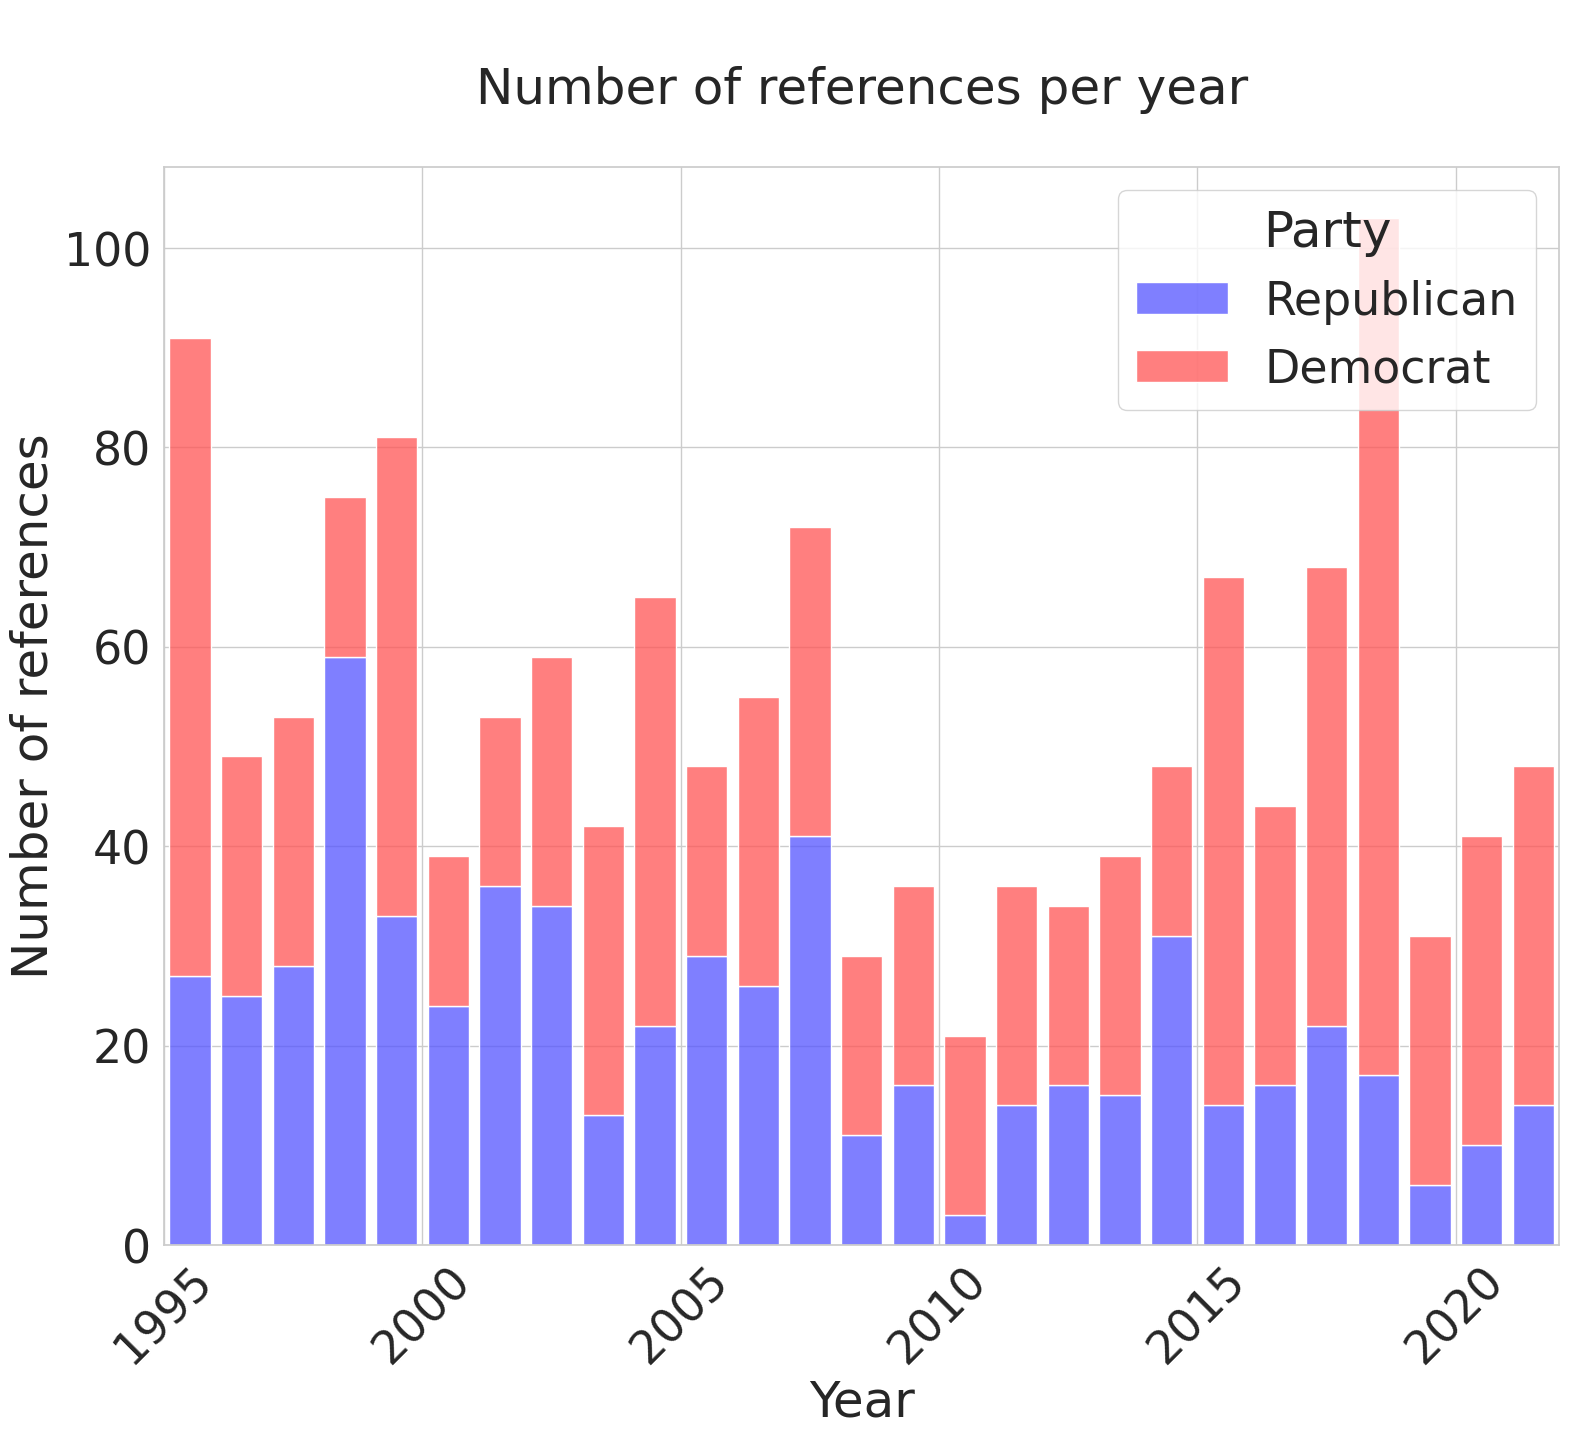

In [70]:
merged_filtered['year'] = merged_filtered['year'].astype(int)
fig, ax = plt.subplots()
sns.histplot(data=merged_filtered, x='year', hue='party', multiple='stack', palette=palette, shrink=0.8, binwidth=1)
plt.title("\nNumber of references per year\n")

# rotate x and only show some
plt.xlabel("Year")
plt.ylabel("Number of references")
plt.legend(title='Party', loc='upper right', labels=['Republican', 'Democrat'])
plt.xticks(rotation=45)
plt.xlim(1995, 2022)

plt.show()

In [71]:
# first, collect number of dem speeches and rep speeches per year
dem_counts = []
rep_counts = []
years = []
for year in range(1995, 2023):
    dem_count = len(full_cr_df[(full_cr_df['year'] == year) & (full_cr_df['party'] == 'Democrat')])
    rep_count = len(full_cr_df[(full_cr_df['year'] == year) & (full_cr_df['party'] == 'Republican')])
    dem_counts.append(dem_count)
    rep_counts.append(rep_count)
    years.append(year)


# number of references per year for dems and reps
dem_refs = merged[merged['party'] == 'Democrat']
rep_refs = merged[merged['party'] == 'Republican']

dem_ref_counts = []
rep_ref_counts = []
for year in range(1995, 2023):
    dem_count = len(dem_refs[dem_refs['year'] == year])
    rep_count = len(rep_refs[rep_refs['year'] == year])
    dem_ref_counts.append(dem_count)
    rep_ref_counts.append(rep_count)

# plot number of references per year wrt party
dem_refs_prop = [dem_ref_counts[i] / dem_counts[i] for i in range(len(dem_counts))]
rep_refs_prop = [rep_ref_counts[i] / rep_counts[i] for i in range(len(rep_counts))]

KeyError: 'party'

NameError: name 'dem_refs_prop' is not defined

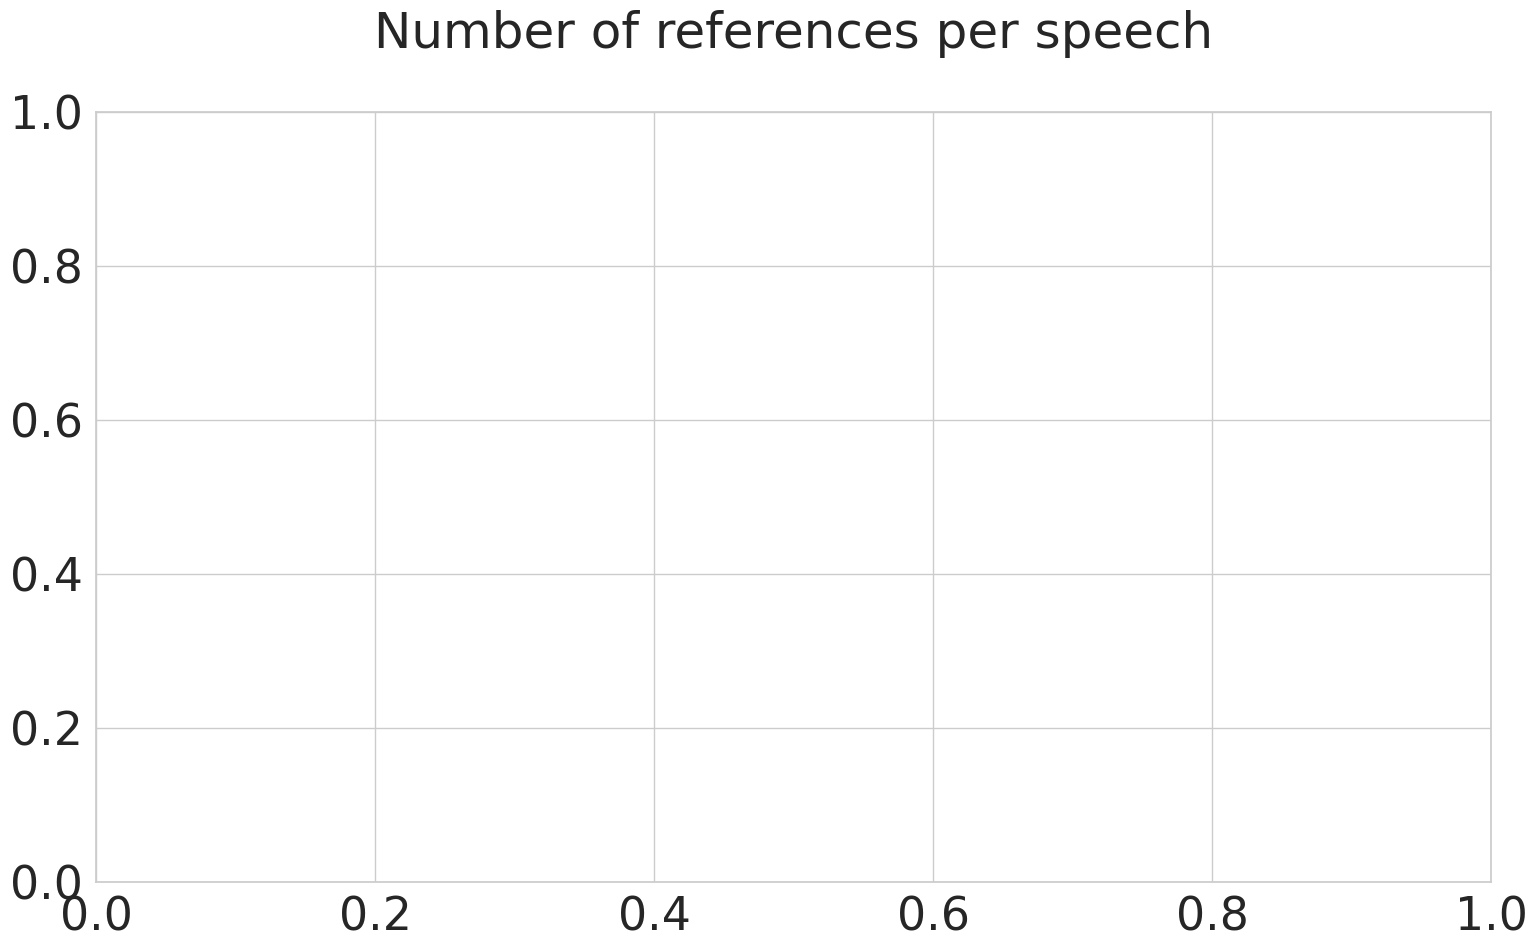

In [ ]:
fig, ax = plt.subplots()
plt.title("Number of references per speech\n")
sns.pointplot(x=years, y=dem_refs_prop, label="Democrat", color='blue', join=False)
sns.pointplot(x=years, y=rep_refs_prop, label="Republican", color='red', join=False)

# rotate x and only show some
plt.xlabel("Year")
plt.ylabel("Number of references per speech")
plt.ylim(0, 0.0015)
plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::3])

plt.show()

In [ ]:
# prop of speeches in a given year that have a reference
dem_ref_in_speech_bin_counts = []
rep_ref_in_speech_bin_counts = []
for year in range(1995, 2023):
    dem_count = len(dem_refs[dem_refs['year'] == year].drop_duplicates(subset=['speech_id']))
    rep_count = len(rep_refs[rep_refs['year'] == year].drop_duplicates(subset=['speech_id']))
    dem_ref_in_speech_bin_counts.append(dem_count)
    rep_ref_in_speech_bin_counts.append(rep_count)

dem_ref_in_speech_bin_prop = [dem_ref_in_speech_bin_counts[i] / dem_counts[i] for i in range(len(dem_counts))]
rep_ref_in_speech_bin_prop = [rep_ref_in_speech_bin_counts[i] / rep_counts[i] for i in range(len(rep_counts))]

NameError: name 'rep_refs' is not defined

NameError: name 'dem_ref_in_speech_bin_prop' is not defined

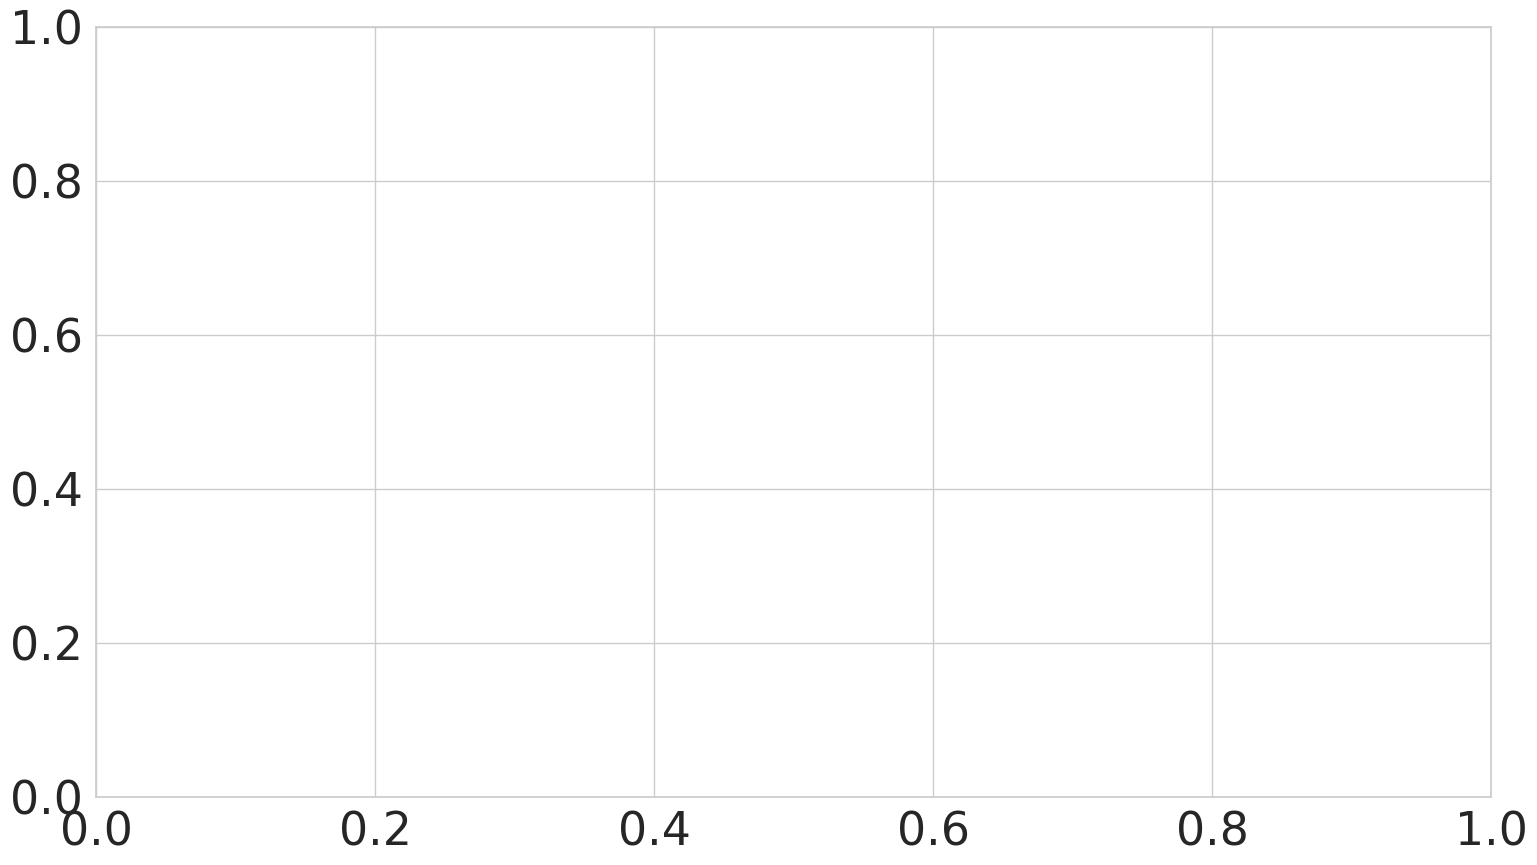

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=years, y=dem_ref_in_speech_bin_prop, label="Democrat", color='blue')
sns.lineplot(x=years, y=rep_ref_in_speech_bin_prop, label="Republican", color='red')

# rotate x and only show some
plt.xlabel("Year")
plt.ylabel("Number of references per speech")
plt.xticks(rotation=45)
ax.set_xticks(ax.get_xticks()[::3])

plt.show()

In [ ]:
# num of republican refs

print(f"Number of republican references: {len(merged[merged['party'] == 'Republican'])}")
print(f"Number of democrat references: {len(merged[merged['party'] == 'Democrat'])}")

Number of republican references: 894
Number of democrat references: 627


In [ ]:
# speeches without rep or dem party
print(f"Number of references: {len(merged)}")
print(f"Number of speeches: {len(merged['speech_id'].unique())}")
print(f"Proportion of speeches with a reference: {len(merged['speech_id'].unique()) / len(df.index)}")
print(f"Number of unique speakers: {len(merged['bio_id'].unique())}")
print(f"Number of unique speakers overall: {len(df['bio_id'].unique())}")

Number of references: 1555
Number of speeches: 898


NameError: name 'df' is not defined

In [ ]:
# number of female and male speakers
print(f"Number of female speakers in references: {len(merged[merged['gender'] == 'F']['bio_id'].unique())}")
print(f"Number of male speakers in references: {len(merged[merged['gender'] == 'M']['bio_id'].unique())}")

Number of female speakers in references: 62
Number of male speakers in references: 292


In [ ]:
# create speaker df by dropping duplicate bio_id
speaker_df = merged.drop_duplicates(subset=['bio_id'])

In [ ]:
print(f"Number of Republican women speakers: {len(speaker_df[(speaker_df['party'] == 'Republican') & (speaker_df['gender'] == 'F')])}")
print(f"Number of Democratic women speakers: {len(speaker_df[(speaker_df['party'] == 'Democrat') & (speaker_df['gender'] == 'F')])}")
print(f"Number of Republican men speakers: {len(speaker_df[(speaker_df['party'] == 'Republican') & (speaker_df['gender'] == 'M')])}")
print(f"Number of Democratic man speakers: {len(speaker_df[(speaker_df['party'] == 'Democrat') & (speaker_df['gender'] == 'M')])}")

Number of Republican women speakers: 25
Number of Democratic women speakers: 37
Number of Republican men speakers: 184
Number of Democratic man speakers: 106


In [ ]:
# for party and gender, print number of speeches and proportion of those speeches with a reference to the bible

# references per speech
for gender in ['F', 'M']:
    for party in ['Democrat', 'Republican']:
        num_refs = len(merged[(merged['party'] == party) & (merged['gender'] == gender)])
        num_speeches = len(full_cr_df[(df['party'] == party) & (df['gender'] == gender)])
        print(f"Number of {party} {gender} references: {num_refs}")
        print(f"Percentage of {party} {gender} speeches with a reference: {num_refs / num_speeches}")

NameError: name 'df' is not defined

In [ ]:
# num unique speakers
print(f"Number of unique speakers: {len(merged['bio_id'].unique())}")
print(f"Proportion of unique speakers: {len(merged['bio_id'].unique()) / len(df['bio_id'].unique())}")

Number of unique speakers: 349
Proportion of unique speakers: 0.21609907120743035


In [ ]:
print(f"Number of unique Democrats: {len(merged[merged['party'] == 'Democrat']['bio_id'].unique())}")
print(f"Number of unique Republicans: {len(merged[merged['party'] == 'Republican']['bio_id'].unique())}")

Number of unique Democrats: 138
Number of unique Republicans: 208


In [ ]:
# gender
print(f"Number of women references: {len(merged[merged['gender'] == 'F'])}")

Number of women references: 174


In [ ]:
merged.columns

Index(['llm_response', 'label_llm', 'verse_llm', 'congress_idx', 'text_x',
       'most_similar_verse', 'shared_ngrams', 'verse_baseline',
       'cosine_similarity', 'speech_id', 'bio_id', 'congress_num', 'year',
       'date', 'chamber', 'speaker', 'text_y', 'month_code', 'month', 'party',
       'state', 'gender'],
      dtype='object')

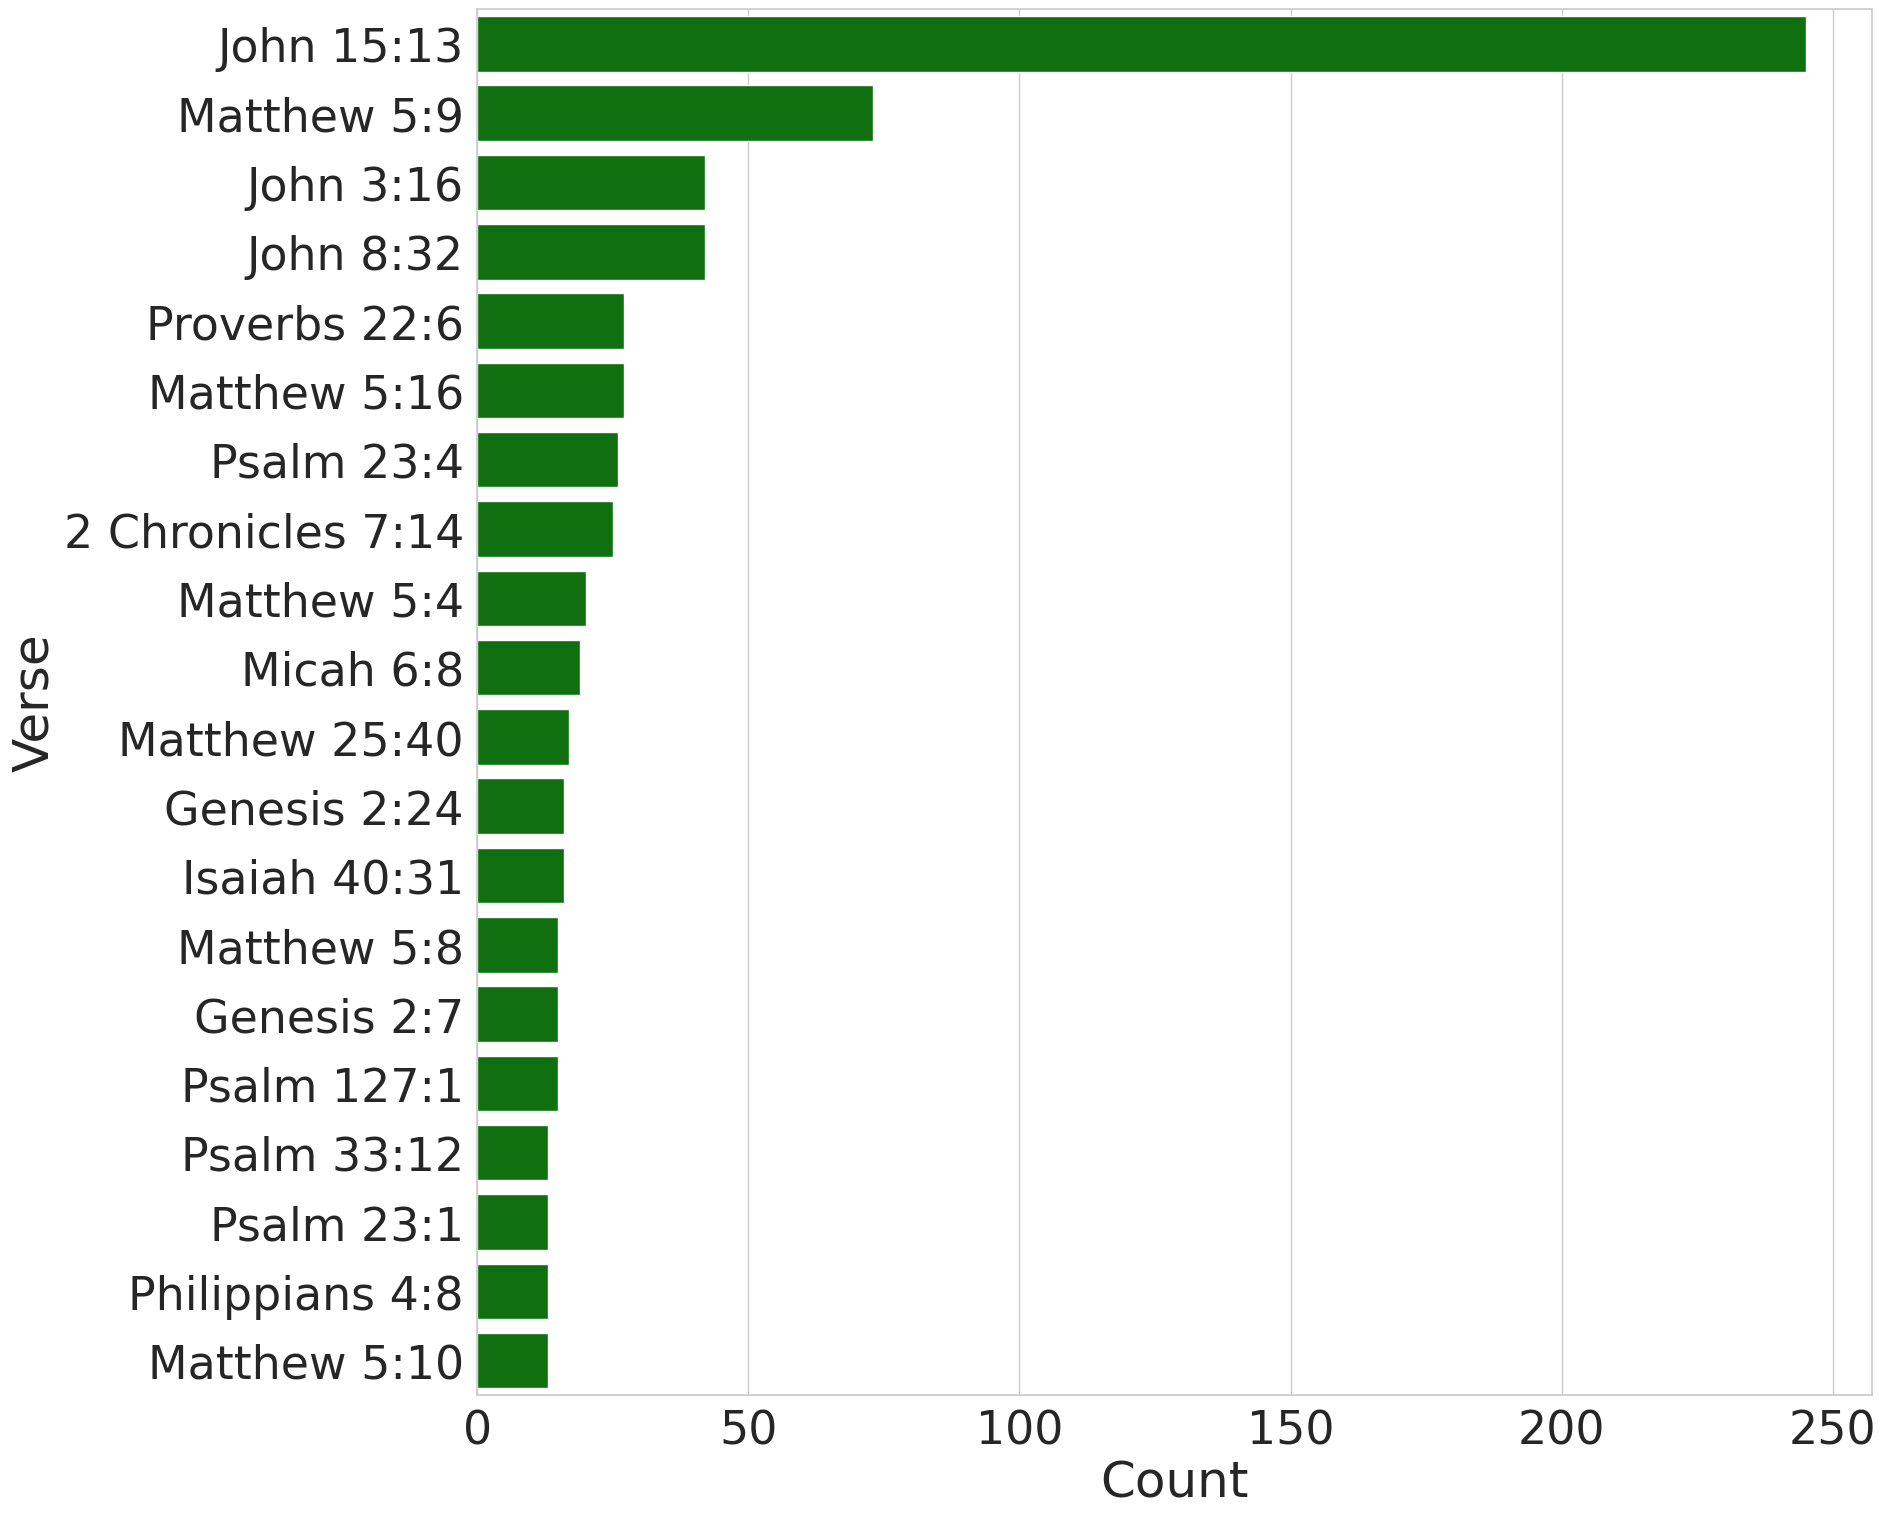

<Figure size 1800x1800 with 0 Axes>

In [ ]:
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,18), 'font.weight': 'normal'}, style='whitegrid')

sns.countplot(y=merged['verse_baseline'], order=merged['verse_baseline'].value_counts().index[:20], color='green')
plt.xlabel("Count")
plt.ylabel("Verse")
plt.show()
plt.savefig("/home/laviniad/projects/religion_in_congress/plots/br_top_20_references.pdf", format='pdf', bbox_inches='tight', dpi=300)


In [ ]:
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/verse_counts.pdf")

<Figure size 1800x1800 with 0 Axes>

In [ ]:
dem_refs = merged[merged['party'] == 'Democrat']
rep_refs = merged[merged['party'] == 'Republican']

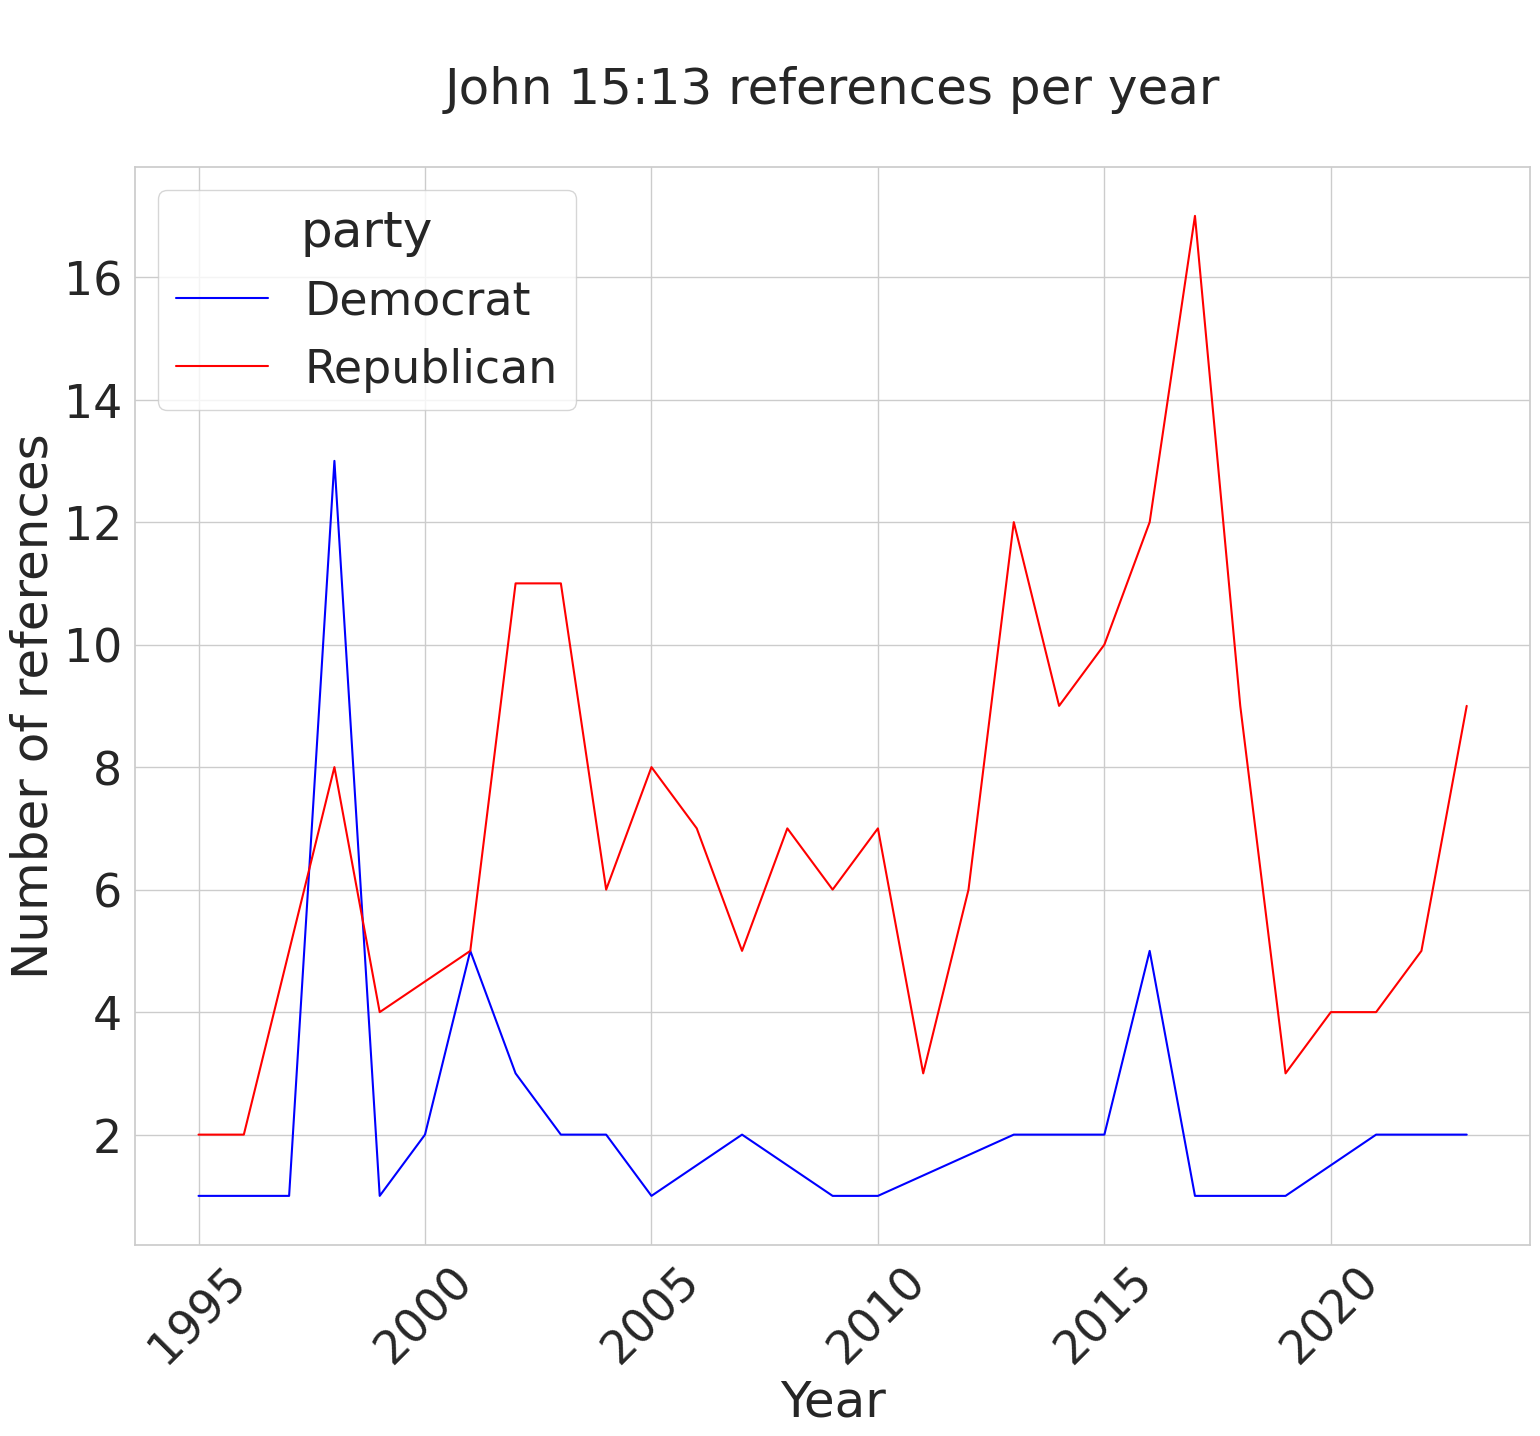

In [ ]:
# lineplot of john 15:13 references per year
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')
john_15_13 = merged[merged['verse_baseline'] == 'John 15:13']
john_15_13 = john_15_13.groupby(['year', 'party']).size()
john_15_13 = john_15_13.reset_index()
john_15_13.columns = ['year', 'party', 'count']
#john_15_13.columns = ['year', 'party', 'count']

fig, ax = plt.subplots()
plt.title("\nJohn 15:13 references per year\n")
sns.lineplot(x='year', y='count', data=john_15_13, hue='party', palette=palette)
plt.xlabel("Year")
plt.ylabel("Number of references")
plt.xticks(rotation=45)
plt.show()


In [ ]:
def clean_baseline(x):
    if isinstance(x, str) and '\'' in x:
        return x.split('\'')[1]
    else:
        return x

merged['verse_baseline'] = merged['verse_baseline'].apply(clean_baseline)

In [ ]:
merged['verse_baseline']

0          John 8:32
1       Matthew 5:44
2         John 15:13
3       Hebrews 11:1
4         John 15:13
            ...     
1550      John 16:33
1551      John 15:12
1552      Romans 5:6
1553       Luke 2:11
1554    Matthew 5:16
Name: verse_baseline, Length: 1555, dtype: object

In [73]:
genesis_2_24_refs = merged[merged['verse_baseline'] == 'Genesis 2:24']
print(genesis_2_24_refs['party'].value_counts())

party
Republican    15
Democrat       1
Name: count, dtype: int64


In [74]:
genesis_2_24_refs[genesis_2_24_refs['party'] == 'Democrat']['bio_id']
print(genesis_2_24_refs[genesis_2_24_refs['party'] == 'Democrat']['text_x'].values[0])
print(genesis_2_24_refs[genesis_2_24_refs['party'] == 'Democrat']['verse_llm'].values[0])

For this cause shall a man leave his father and mother, and cleave to his wife; And they twain shall be one flesh: so then they are no more twain, but one flesh.
Mark 10:7-8


In [75]:
# print rows where verse_llm and verse_baseline are different
diff_verses = merged[merged['verse_llm'] != merged['verse_baseline']]
print(diff_verses)

                                    llm_response  label_llm  \
22                         Verse\nProverbs 3:5-6       True   
34                     Verse\nColossians 3:23-24       True   
41                         Verse\nRomans 1:18-19       True   
56                            Verse\nLuke 2:8-14       True   
61    Verse\nGalatians 6:9 and 2 Corinthians 5:7       True   
...                                          ...        ...   
1482                      Verse\n2 Timothy 4:3-4       True   
1494                        Verse\nMatthew 22:37       True   
1511                    Verse\nGalatians 5:22-23       True   
1517                          Verse\nPsalms 24:1       True   
1524                            Verse\nJohn 8:12       True   

                                verse_llm     congress_idx  \
22                         Proverbs 3:5-6            98555   
34                     Colossians 3:23-24           135999   
41                         Romans 1:18-19           19179

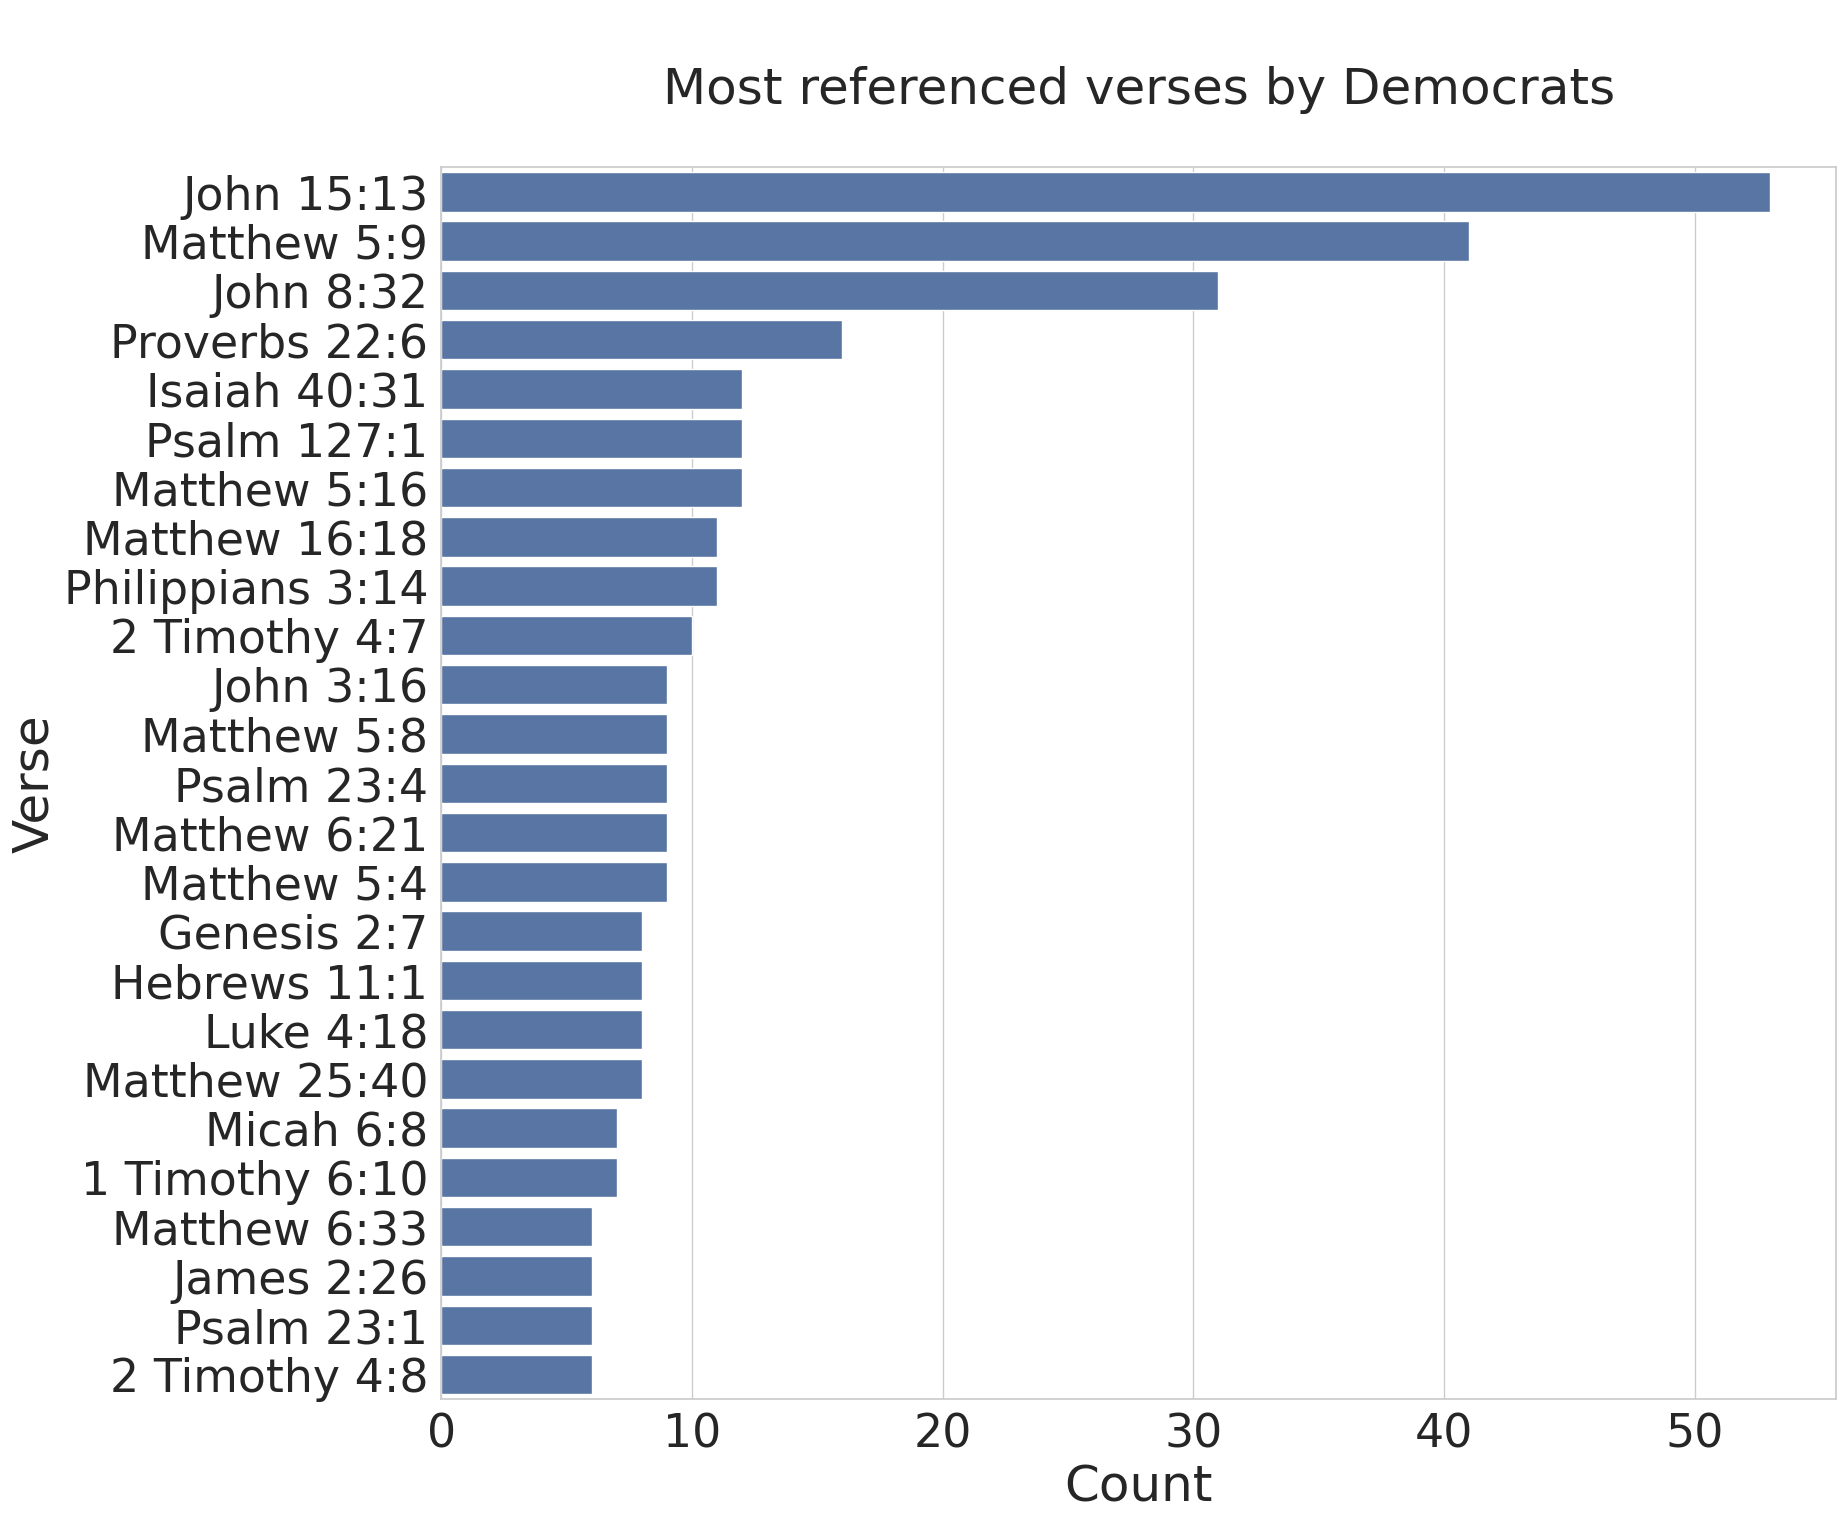

In [76]:
# separate by party

# for y axis: color verse if not in republican top 25

plt.figure(figsize=(18, 16))
plt.title("\nMost referenced verses by Democrats\n")

sns.countplot(y=dem_refs['verse_baseline'], order=dem_refs['verse_baseline'].value_counts().index[:25])

plt.xlabel("Count")
plt.ylabel("Verse")
plt.show()

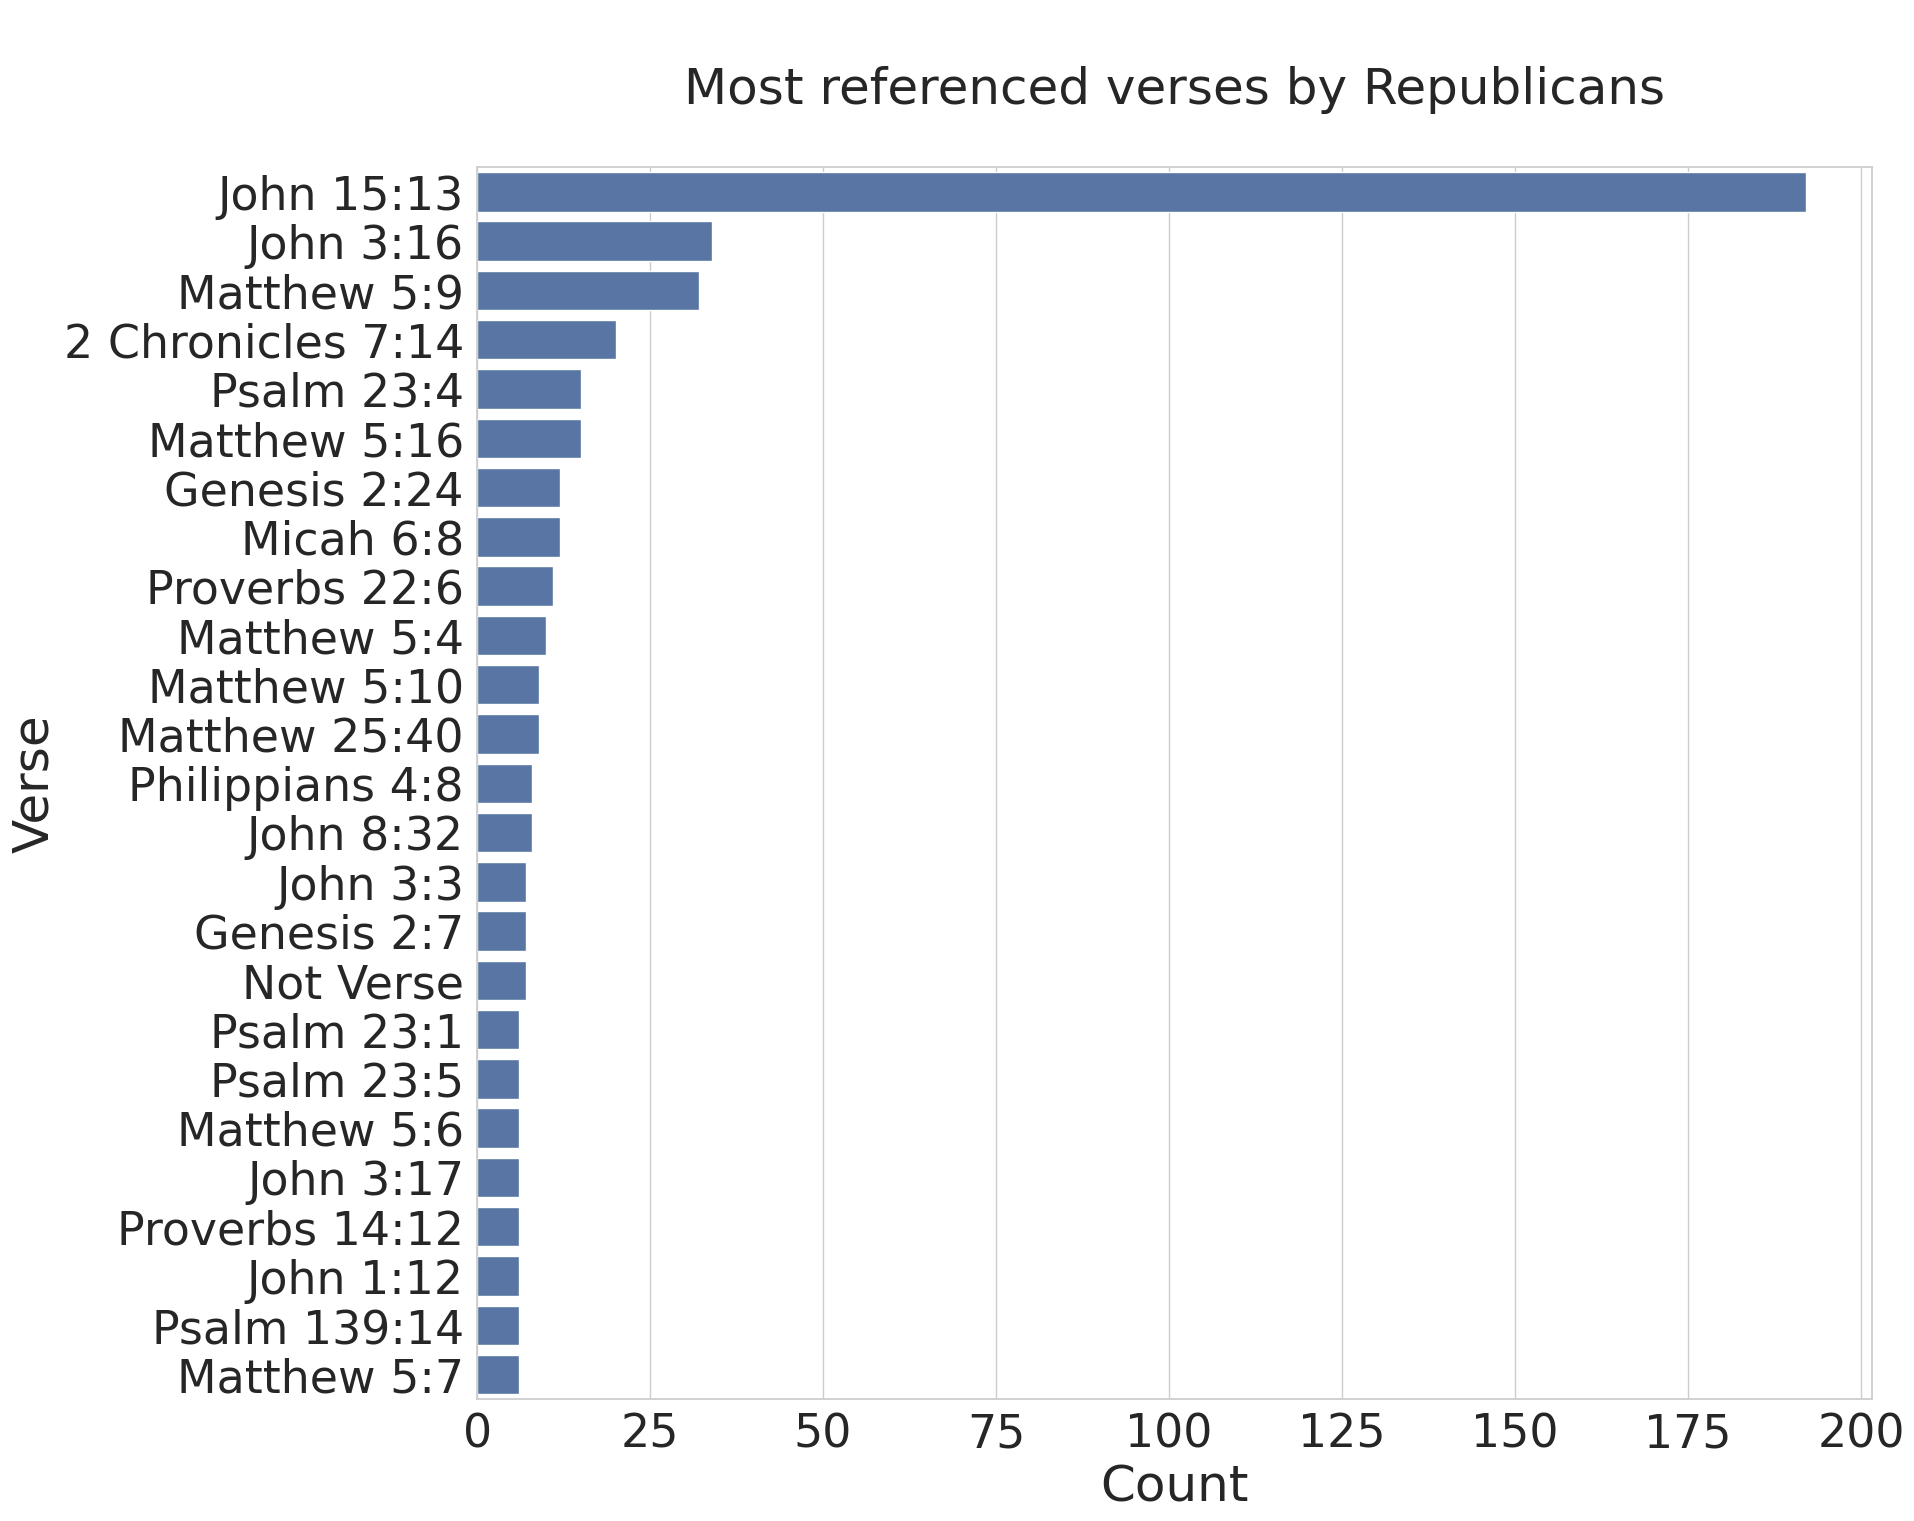

In [77]:
plt.figure(figsize=(18, 16))
plt.title("\nMost referenced verses by Republicans\n")
sns.countplot(y=rep_refs['verse_llm'], order=rep_refs['verse_llm'].value_counts().index[:25])
plt.xlabel("Count")
plt.ylabel("Verse")
plt.show()

In [78]:
def kld_of_two_dists(dist1, dist2):
    """
    Calculate the Kullback-Leibler divergence between two distributions.
    """
    # Ensure both distributions are normalized
    dist1 = dist1 / np.sum(dist1)
    dist2 = dist2 / np.sum(dist2)

    # Avoid division by zero and log(0) by adding a small constant
    epsilon = 1e-10
    dist1 = np.clip(dist1, epsilon, None)
    dist2 = np.clip(dist2, epsilon, None)

    return np.sum(dist1 * np.log(dist1 / dist2))

def kld_of_verse_party_counts(dem_counts, rep_counts):
    """
    Calculate the Kullback-Leibler divergence between the verse distributions of Democrats and Republicans.
    """

    # Get the union of all verses
    #all_verses = set(dem_counts.index).union(set(rep_counts.index))

    # Create distributions for both parties
    #dem_dist = np.array([dem_counts.get(verse, 0) for verse in all_verses])
    #rep_dist = np.array([rep_counts.get(verse, 0) for verse in all_verses])

    # Calculate KLD
    kld = kld_of_two_dists(dem_counts, rep_counts)
    return kld


def null_permutation_test(dem_counts, rep_counts, kld_obs, num_permutations=1000):
    """
    Perform a null permutation test to assess the significance of the KLD between two distributions.
    """
    # Combine the counts
    combined = np.concatenate([dem_counts, rep_counts])
    n = len(dem_counts)

    # Store KLD values for null distributions
    kld_null = []

    for _ in range(num_permutations):
        np.random.shuffle(combined)
        p_perm = combined[:n]
        q_perm = combined[n:]
        kld_null.append(kld_of_two_dists(p_perm, q_perm))

    p_value = np.mean(np.array(kld_null) >= kld_obs)

    return kld_null, p_value


In [79]:
from scipy.stats import chi2_contingency, binomtest
from statsmodels.stats.multitest import multipletests


# P_counts and Q_counts are dictionaries of verses pointing to counts
def calculate_chi2(p_counts, q_counts):
    statistics = []
    p_vals = []

    for p, q in zip(p_counts, q_counts):
        statistic, pval, _, _ = chi2_contingency(np.array([p,q]))
        
        statistics.append(statistic)
        p_vals.append(pval)

    return statistics, p_vals

def calculate_fdr(pvals):
    # Adjust p-values for multiple comparisons using the Benjamini-Hochberg method
    rej, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')

    return rej, pvals_corrected

def calculate_bonferroni(pvals):
    # Adjust p-values for multiple comparisons using the Bonferroni method
    rej, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')

    return rej, pvals_corrected


In [80]:
import numpy as np
from statsmodels.stats.multitest import multipletests

# Get the counts of each verse for Democrats and Republicans
dem_counts = dem_refs['verse_baseline'].value_counts()
rep_counts = rep_refs['verse_baseline'].value_counts()

dem_counts_with_zeroes = []
rep_counts_with_zeroes = []
# Ensure both dictionaries have the same keys
all_keys = list(set(dem_counts.keys()).union(set(rep_counts.keys())))
for key in all_keys:
    dem_counts_with_zeroes.append(dem_counts.get(key, 0))
    rep_counts_with_zeroes.append(rep_counts.get(key, 0))

P_counts = dem_counts_with_zeroes
Q_counts = rep_counts_with_zeroes
total_P = np.sum(P_counts)
total_Q = np.sum(Q_counts)

pvals = []
counter = 0
for p, q in zip(P_counts, Q_counts):
    print(p)
    print(q)
    verse = all_keys[counter]
    alt = 'greater'
    #alt = 'two-sided'
    result = binomtest(q, p + q, p=0.5, alternative='two-sided')

    pval = result.pvalue
    stat = result.statistic
    print(f"Verse: {verse}, p-value: {pval}, statistic: {stat}")
    pvals.append(pval)
    counter += 1

# Multiple testing correction
rej, pvals_corrected, _, _ = multipletests(pvals, method='bonferroni')
significant_features = np.where(rej)[0]


0
1
Verse: Proverbs 18:24, p-value: 1.0, statistic: 1.0
1
2
Verse: Joshua 24:15, p-value: 1.0, statistic: 0.6666666666666666
7
3
Verse: 1 Timothy 6:10, p-value: 0.34375, statistic: 0.3
6
1
Verse: Matthew 6:33, p-value: 0.125, statistic: 0.14285714285714285
2
0
Verse: Matthew 6:11, p-value: 0.5, statistic: 0.0
0
4
Verse: Matthew 7:12, p-value: 0.125, statistic: 1.0
16
11
Verse: Proverbs 22:6, p-value: 0.44206833839416504, statistic: 0.4074074074074074
0
2
Verse: Romans 15:7, p-value: 0.5, statistic: 1.0
0
1
Verse: Philippians 2:13, p-value: 1.0, statistic: 1.0
0
1
Verse: John 1:9, p-value: 1.0, statistic: 1.0
2
0
Verse: Matthew 6:5, p-value: 0.5, statistic: 0.0
2
1
Verse: John 20:28, p-value: 1.0, statistic: 0.3333333333333333
53
192
Verse: John 15:13, p-value: 1.1037708069321025e-19, statistic: 0.7836734693877551
3
0
Verse: Matthew 7:7, p-value: 0.25, statistic: 0.0
2
2
Verse: Exodus 20:3, p-value: 1.0, statistic: 0.5
0
1
Verse: John 15:8, p-value: 1.0, statistic: 1.0
2
0
Verse: Galati

In [81]:
significant_features

array([12])

In [82]:
len(all_keys)

279

In [83]:
# get chi2 difference between dem_counts_with_zeroes and rep_counts_with_zeroes after smoothing by adding 1 to each count
dem_counts_smooth = [x + 1 for x in dem_counts_with_zeroes]
rep_counts_smooth = [x + 1 for x in rep_counts_with_zeroes]
dem_counts_smooth = np.array(dem_counts_smooth)
rep_counts_smooth = np.array(rep_counts_smooth)

stat, pval, _, _ = chi2_contingency([dem_counts_smooth, rep_counts_smooth])

In [84]:
print("Chi2 statistic: ", stat)
print("P-value: ", pval)

Chi2 statistic:  393.28802134711395
P-value:  6.258858141750789e-06


In [85]:
print("Significant verses after Bonferroni correction: ")
for i in significant_features:
    print(all_keys[i], pvals_corrected[i])

Significant verses after Bonferroni correction: 
John 15:13 3.079520551340566e-17


In [88]:

# get 25 most popular refs
most_popular_refs = merged['verse_llm'].value_counts()
most_popular_refs_20 = most_popular_refs.index[:20]
# sort largest absolute val to smallest
most_popular_refs_20 = most_popular_refs_20[np.argsort(merged['verse_llm'].value_counts().values[:20])]


/tmp/ipykernel_717930/3046652448.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('coolwarm')


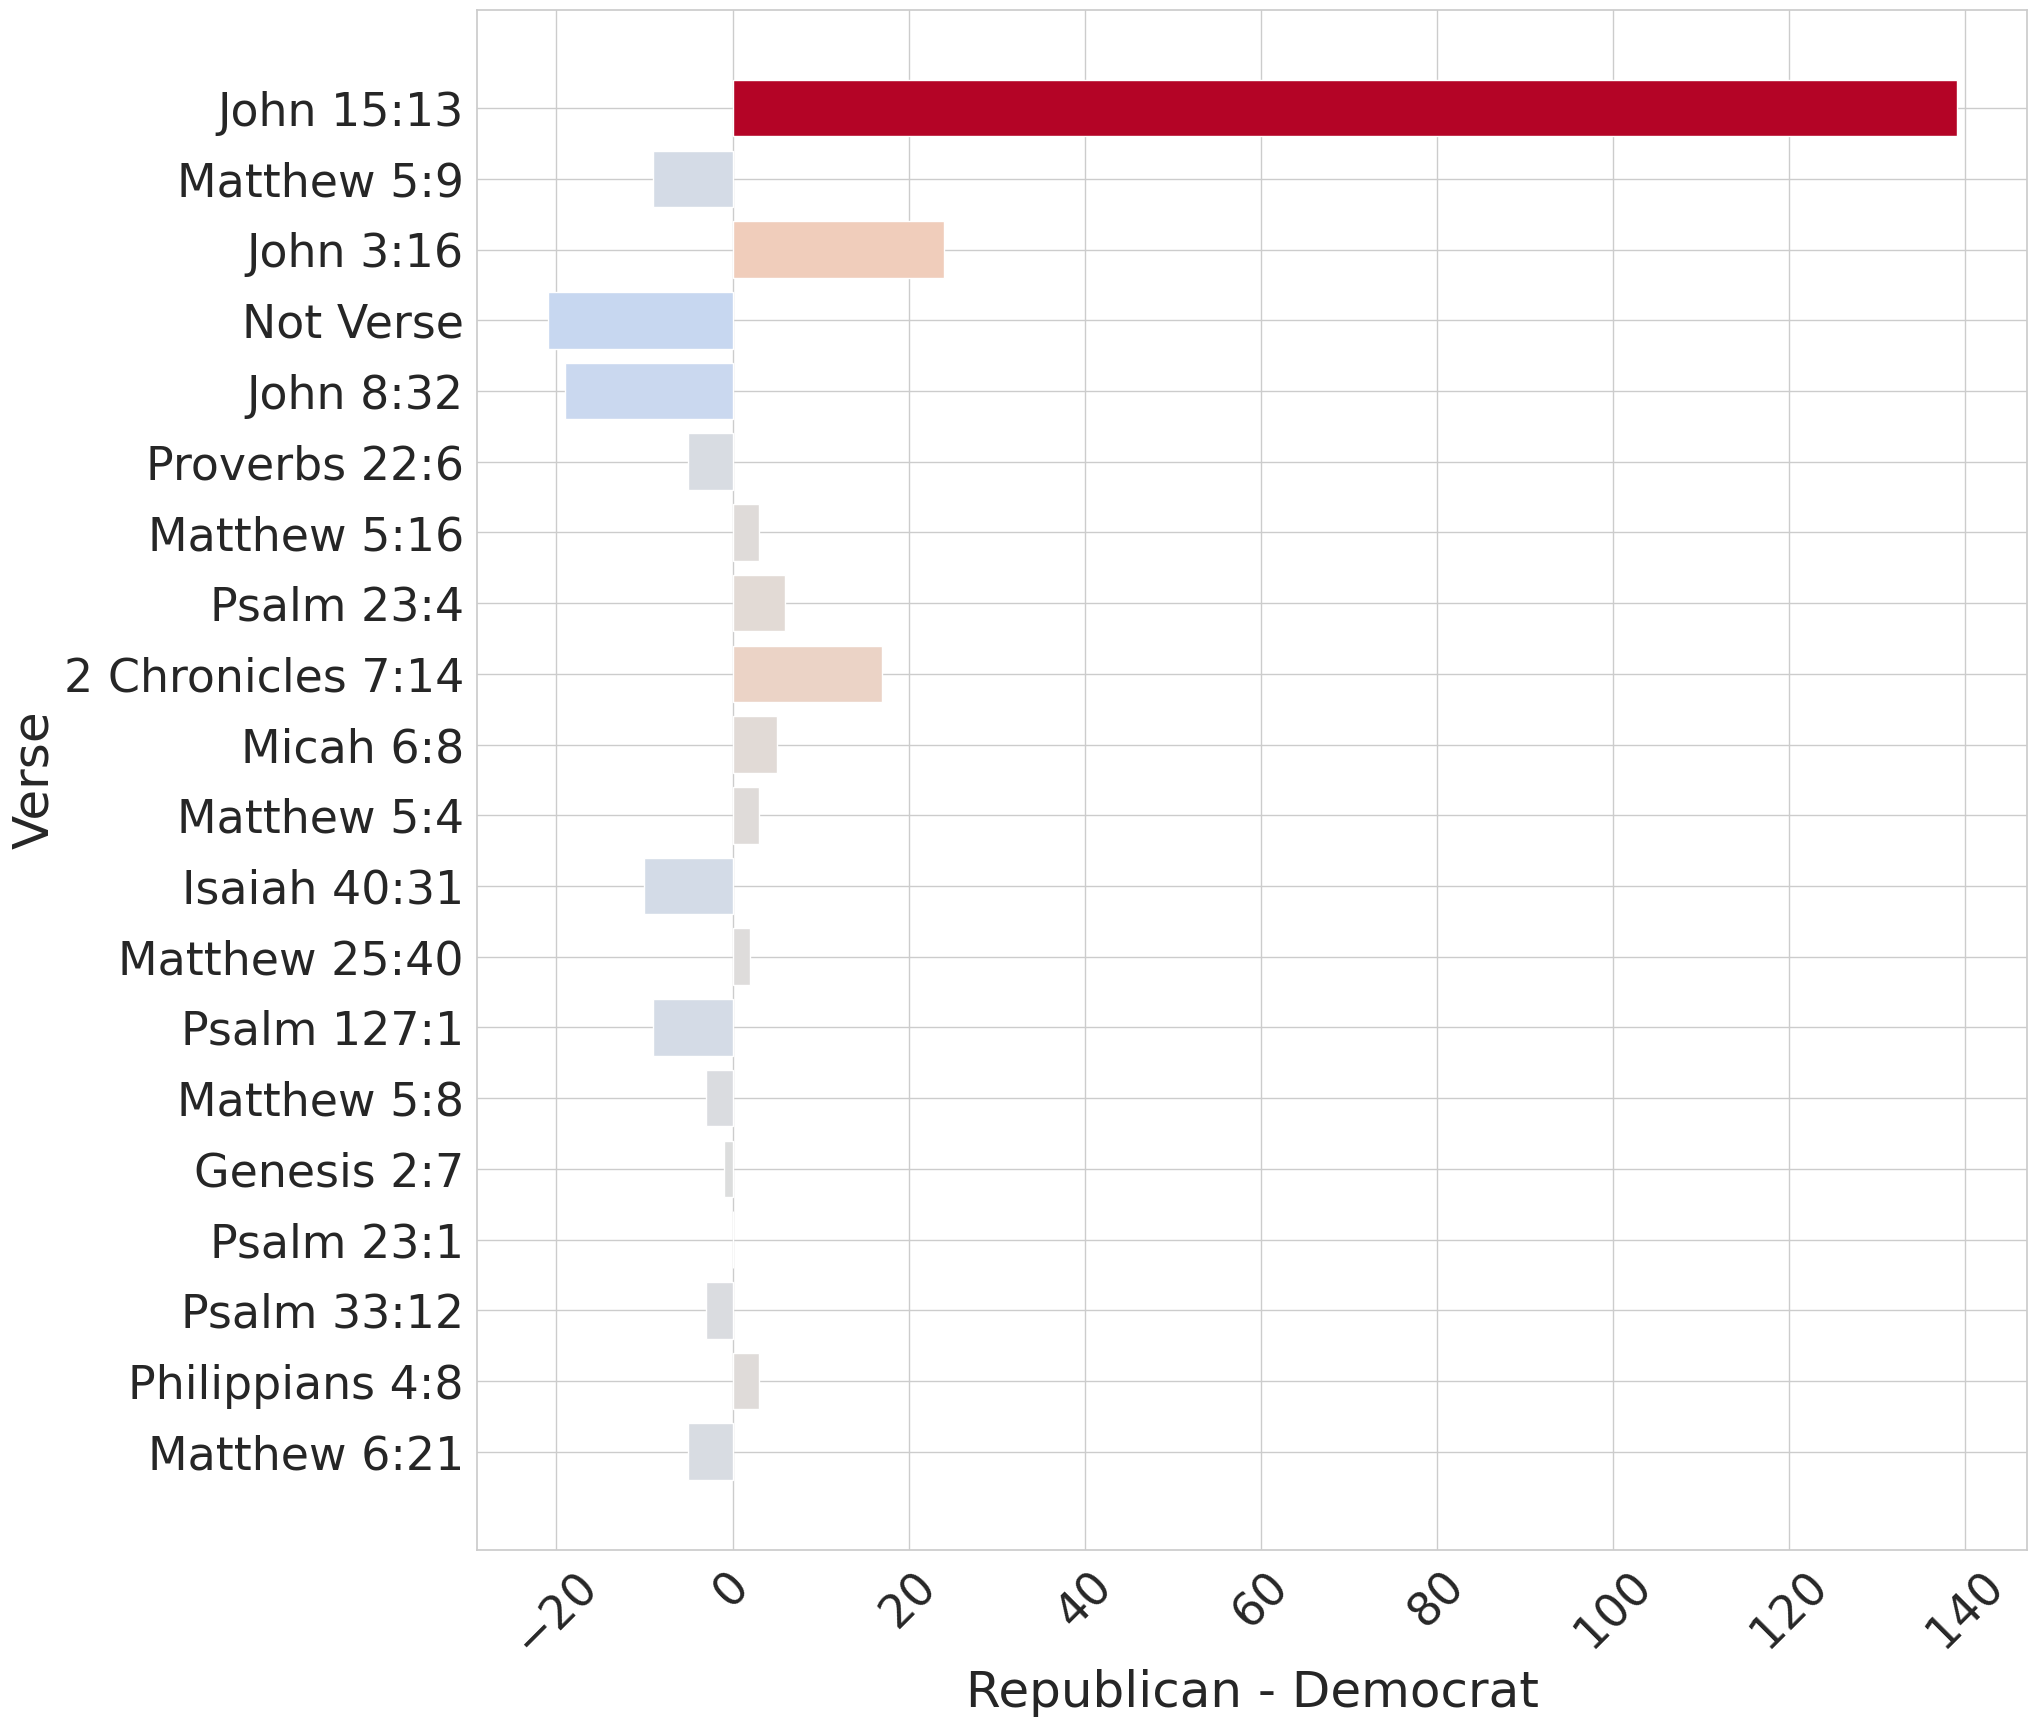

In [90]:
# partisan differences in references

from matplotlib.colors import Normalize
import matplotlib.cm as cm

# for 25 most popular refs overall, calc rep - dem
# for each verse, calc rep - dem

# get counts for each party
dem_counts = []
rep_counts = []

for ref in most_popular_refs_20:
    dem_count = len(dem_refs[dem_refs['verse_llm'] == ref])
    rep_count = len(rep_refs[rep_refs['verse_llm'] == ref])
    dem_counts.append(dem_count)
    rep_counts.append(rep_count)

# get difference
diffs = np.array(rep_counts) - np.array(dem_counts)

palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(20,20), 'font.weight': 'normal'}, style='whitegrid')

# plot
fig, ax = plt.subplots()

cmap = cm.get_cmap('coolwarm')
norm = Normalize(vmin=-np.max(np.abs(diffs)), vmax=np.max(np.abs(diffs)))
colors = [cmap(norm(value)) for value in diffs]

#sns.barplot(y=most_popular_refs_25, x=diffs, hue=diffs, palette='coolwarm')
bars = ax.barh(most_popular_refs_20, diffs, color=colors)
plt.ylabel("Verse")
plt.xlabel("Republican - Democrat")
plt.xticks(rotation=45)
plt.legend('',frameon=False)
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/partisan_diffs_in_brs.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from scipy.stats import chi2_contingency, fisher_exact

pvals = []
for p, q in zip(P_counts, Q_counts):
    contingency = np.array([[p, q]])
    
    # Chi-squared test (reshape to 2x1 so scipy can work with it)
    _, pval, _, _ = chi2_contingency(np.array([[p, q], [sum(P_counts)-p, sum(Q_counts)-q]]))
    
    # Optional: use fisher_exact if counts are low
    # _, pval = fisher_exact([[p, q], [sum(P_counts)-p, sum(Q_counts)-q]])
    
    pvals.append(pval)


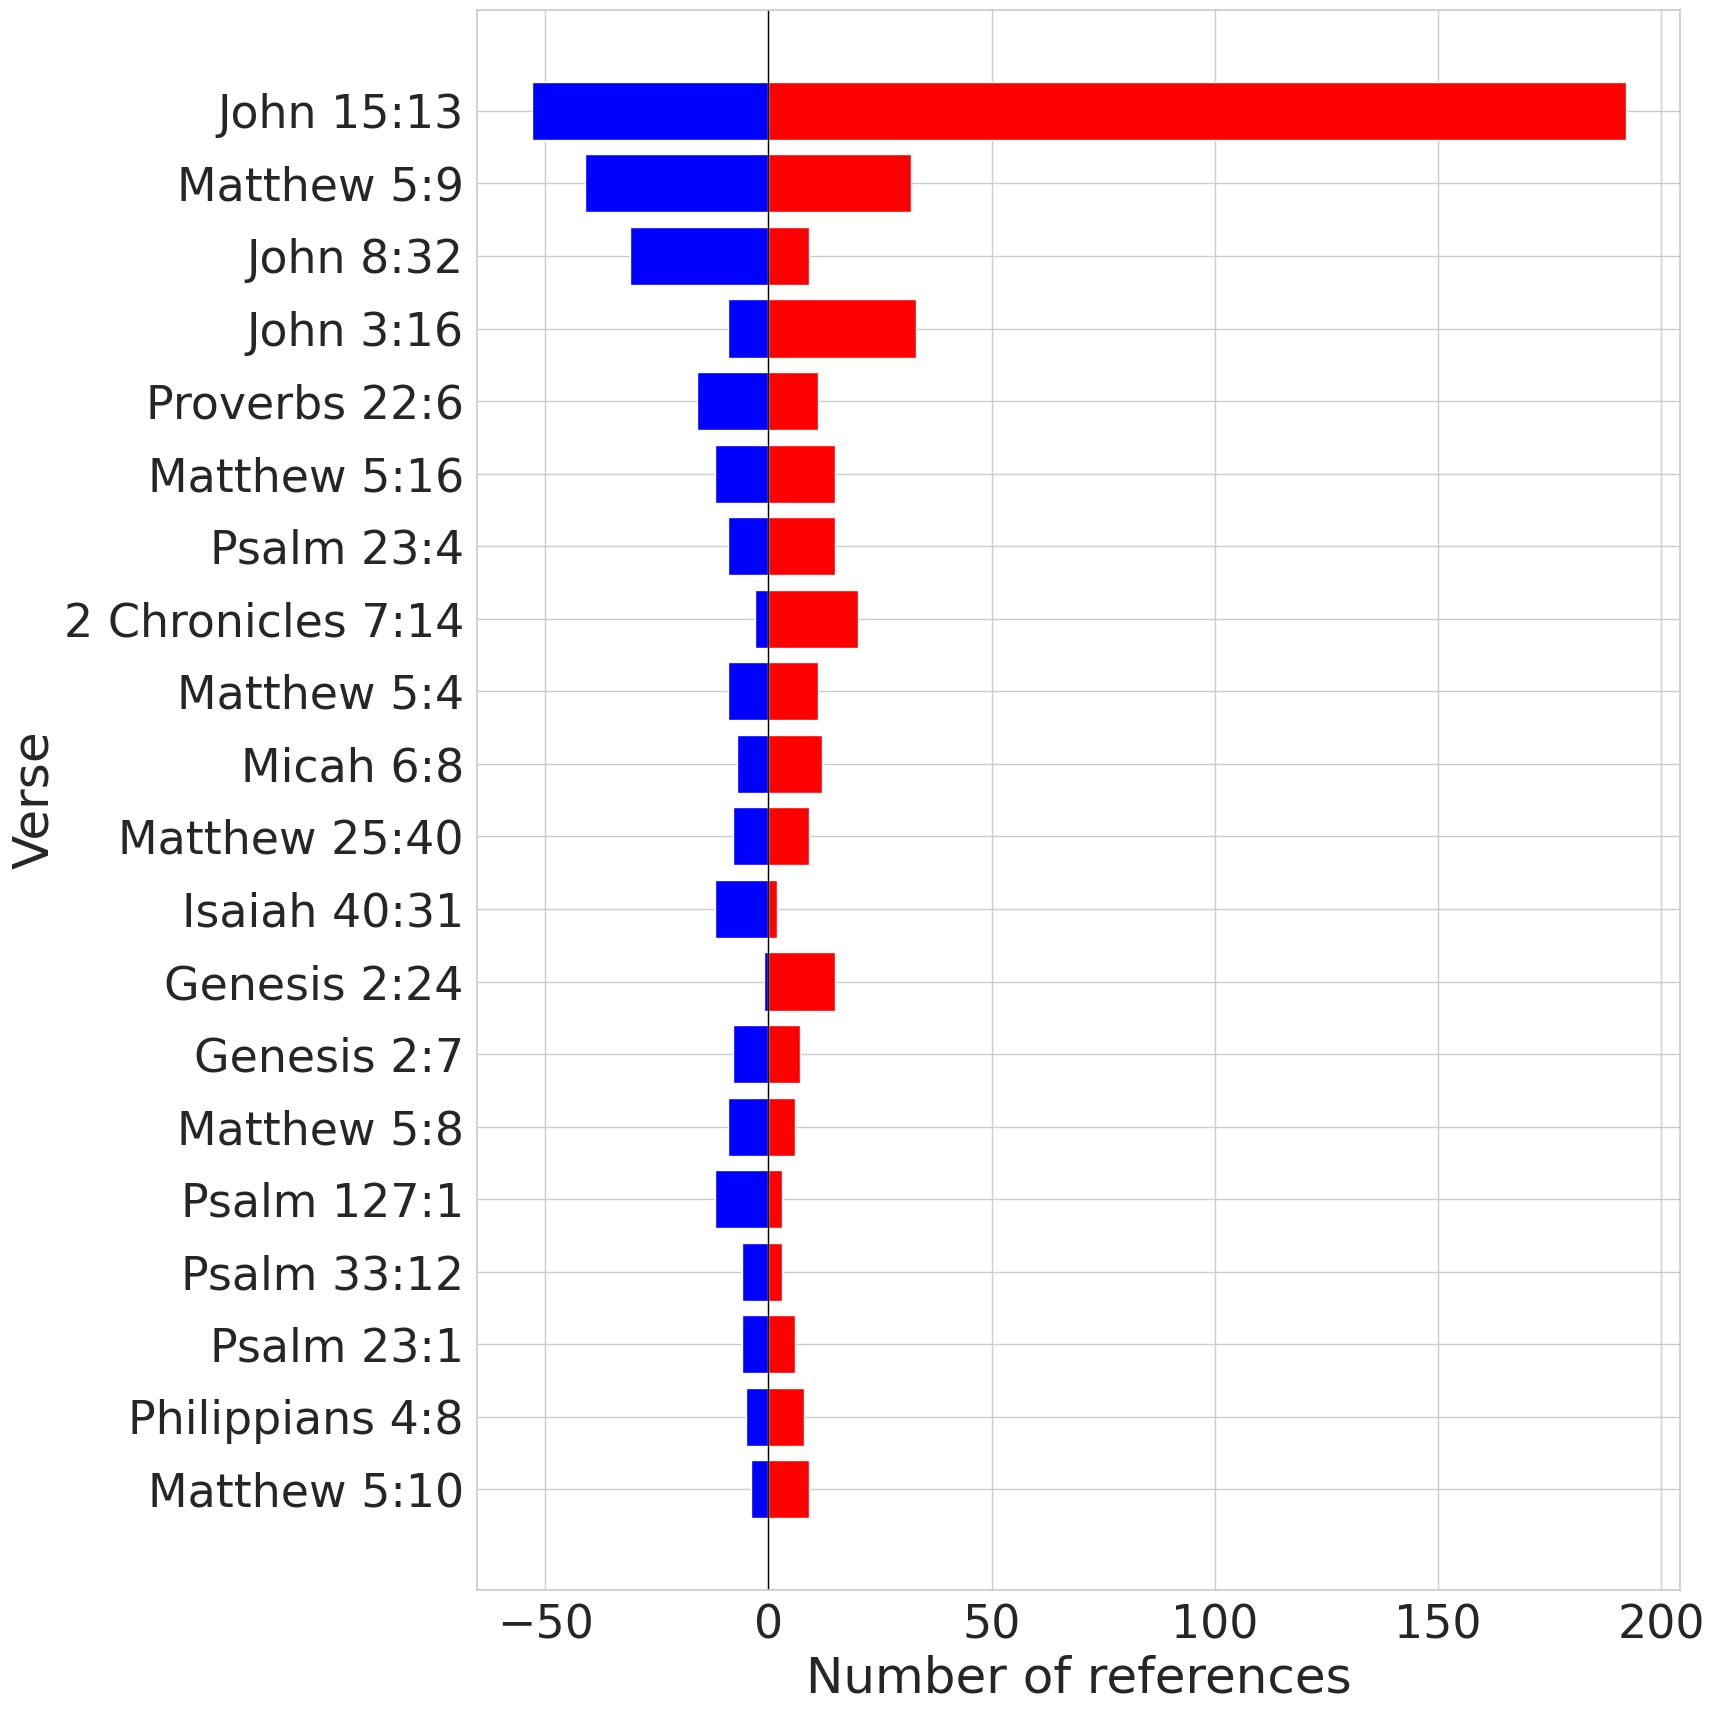

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set_theme(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')
# Prepare the data
most_popular_refs_20 = merged['verse_baseline'].value_counts().index[:20]
most_popular_refs_20 = most_popular_refs_20[np.argsort(merged['verse_baseline'].value_counts().values[:20])]

# reverse for correct bar alignment (so the top bar in plot matches the top label)
most_popular_refs_20 = most_popular_refs_20[::-1]

dem_counts = []
rep_counts = []

for ref in most_popular_refs_20:
    dem_count = len(dem_refs[dem_refs['verse_baseline'] == ref])
    rep_count = len(rep_refs[rep_refs['verse_baseline'] == ref])
    dem_counts.append(dem_count)
    rep_counts.append(rep_count)

# Reverse for correct bar alignment (so the top bar in plot matches the top label)
most_popular_refs_20 = most_popular_refs_20[::-1]
dem_counts = dem_counts[::-1]
rep_counts = rep_counts[::-1]

# Create figure
fig, ax = plt.subplots()

y = np.arange(len(most_popular_refs_20))

# Plot bars
ax.barh(y, rep_counts, color='red', label='Republican')
ax.barh(y, [-c for c in dem_counts], color='blue', label='Democrat')  # Negative to go left

# Labeling
ax.set_yticks(y)
ax.set_yticklabels(most_popular_refs_20)
ax.set_xlabel("Number of references")
ax.set_ylabel("Verse")
ax.axvline(0, color='black', linewidth=1)  # Vertical line at center

# Save and show
plt.tight_layout()
plt.savefig("/home/laviniad/projects/religion_in_congress/plots/br_partisan_counts_both_sides.pdf", format='pdf', bbox_inches='tight', dpi=300)
plt.show()


In [ ]:
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/partisan_verse_use_diffs.pdf")

<Figure size 2000x2000 with 0 Axes>

In [ ]:
len(merged['reference'].unique())

336

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

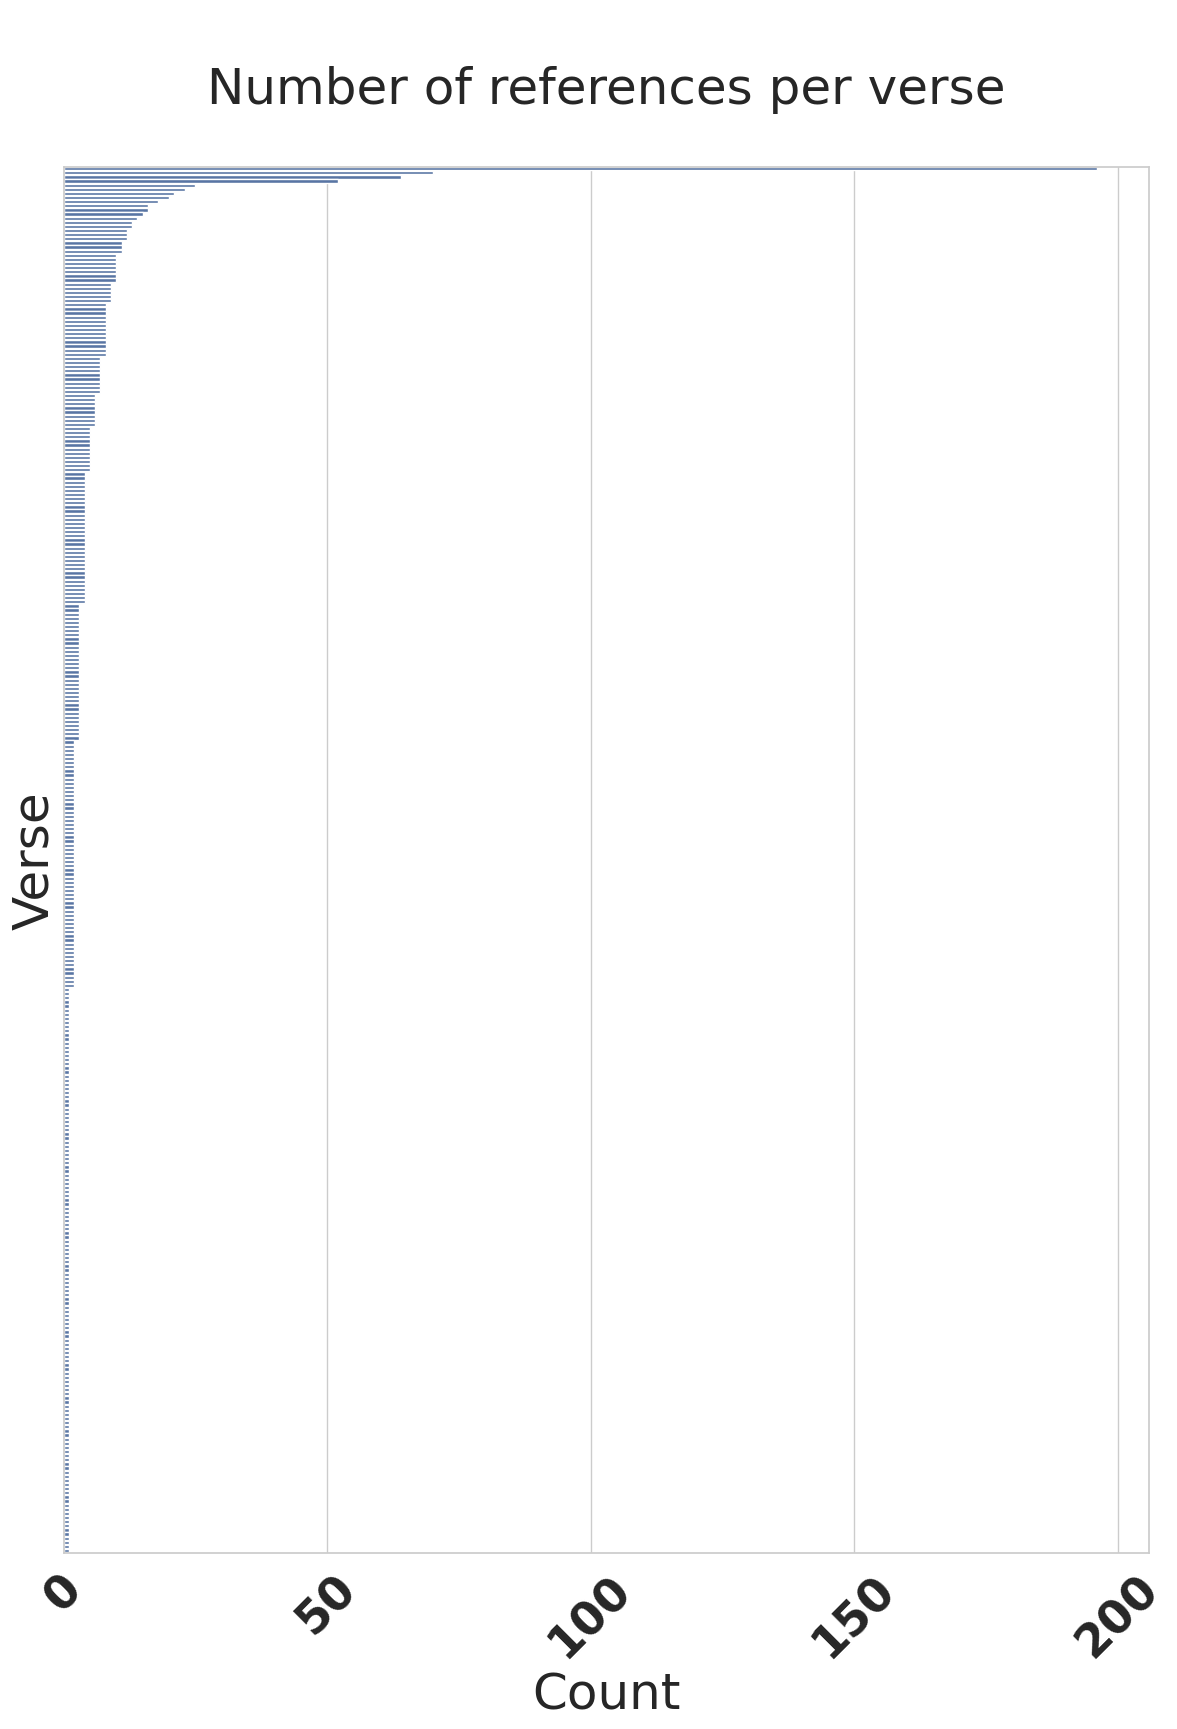

In [ ]:
# plot count for each verse
verse_counts = merged['reference'].value_counts()
verse_counts = verse_counts.reset_index()
verse_counts.columns = ['verse', 'count']

fig, ax = plt.subplots(figsize=(14, 18))
plt.title("\nNumber of references per verse\n")
sns.barplot(y='verse', x='count', data=verse_counts)
plt.ylabel("Verse")
# turn off yticks
plt.yticks([])
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# difference with sermon data...

# load sermon data
SERMON_PATH = '/data/laviniad/sermons-ir/sermoncentral/with_columns.csv'
sermon_refs = pd.read_csv(SERMON_PATH)

In [ ]:
sermon_refs.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'index', 'link', 'denomination', 'author',
       'churchName', 'churchAddress', 'unknown1', 'unknown2', 'unknown3',
       'date', 'title', 'versesList', 'topicsList', 'ratingsNumber', 'rating',
       'text'],
      dtype='object')

In [ ]:
def convert_verse_range_to_list_of_verses(verse_citation):
    # given a verse range, convert it to a list of verses
    # e.g., ephesians 6:1-3 -> [ephesians 6:1, ephesians 6:2, ephesians 6:3]
    #print(verse_citation)

    if '-' not in verse_citation:
        return [verse_citation]

    verses = []
    citation_spaced = verse_citation.split(' ')
    book, verse_num = citation_spaced[:-1], citation_spaced[-1]
    book = ' '.join(book) if len(book) > 1 else book[0]
    verse_range = verse_num.split('-')
    start, end = verse_range[0], verse_range[1]
    if len(verse_range) > 2:
        print(f"Error: {verse_citation}")
        return [verse_citation]

    #print(book, start, end)

    if ':' in start:
        start_chapter, start_verse = start.split(':')
        if start_chapter == '' or start_verse == '' or end == '':
            print(f"End: {end}")
            print(f"Error: {verse_citation}")

        if ':' in end:
            end_chapter, end_verse = end.split(':')
            if end_chapter == '' or end_verse == '':
                print(f"End: {end}")
                print(f"Error: {verse_citation}")

            for i in range(int(start_verse), int(end_verse)+1):
                verses.append(f"{book} {start_chapter}:{i}")
            return verses
        else:
            for i in range(int(start_verse), int(end)+1):
                verses.append(f"{book} {start_chapter}:{i}")
            return verses
    
    else:
        return [verse_citation] # this is strange, i.e. doesn't follow citation pattern

In [ ]:
import ast

# get verse counts

vl = sermon_refs['versesList'].tolist()
verse_counts = {}
for v in vl:
    v_list = ast.literal_eval(v) # --> list of verse citations
    v_list = [convert_verse_range_to_list_of_verses(verse) for verse in v_list if verse != '']
    # flatten
    v = [item for sublist in v_list for item in sublist]

    for verse in v:
        if verse in verse_counts and len(verse) > 1:
            verse_counts[verse] += 1
        elif len(verse) > 1:
            verse_counts[verse] = 1

Error: luke 17:6-17:-11


In [ ]:
verse_counts

{'ephesians 6:11': 521,
 'ephesians 6:12': 571,
 'ephesians 6:13': 524,
 'ephesians 6:14': 503,
 'ephesians 6:15': 474,
 'ephesians 6:16': 474,
 'ezekiel 47:3': 35,
 'ezekiel 47:4': 35,
 'ezekiel 47:5': 35,
 'psalms 8:2': 64,
 '2 kings 17:20': 3,
 '2 kings 17:21': 3,
 '2 kings 17:22': 3,
 '2 kings 17:23': 3,
 '2 kings 17:24': 1,
 '2 kings 17:25': 1,
 '1 thessalonians 5:8': 85,
 'isaiah 40:11': 70,
 '1 corinthians 3:1': 109,
 '1 corinthians 3:2': 105,
 '1 corinthians 3:3': 110,
 '1 corinthians 3:4': 93,
 '1 corinthians 3:5': 112,
 '1 corinthians 3:6': 124,
 '1 corinthians 3:7': 119,
 '1 corinthians 3:8': 118,
 '1 corinthians 3:9': 143,
 'john 14:1': 407,
 'john 14:2': 408,
 'john 14:3': 405,
 'john 14:4': 362,
 'john 14:5': 340,
 'john 14:6': 488,
 'john 14:7': 211,
 'john 14:8': 174,
 'john 14:9': 177,
 'john 14:10': 170,
 'john 14:11': 164,
 'john 14:12': 186,
 'john 14:13': 172,
 'john 14:14': 168,
 'luke 1:5': 187,
 'luke 1:6': 187,
 'luke 1:7': 187,
 'luke 1:8': 185,
 'luke 1:9': 1

In [ ]:
verse_counts_without_ranges = {}
for v in vl:
    v_list = ast.literal_eval(v)
    for verse in v_list:
        if '-' not in verse:
            if verse in verse_counts_without_ranges:
                verse_counts_without_ranges[verse] += 1
            else:
                verse_counts_without_ranges[verse] = 1

In [ ]:
sermon_verse_counts = pd.DataFrame(list(verse_counts.items()), columns=['verse', 'count'])

In [ ]:
sermon_verse_counts_no_ranges = pd.DataFrame(list(verse_counts_without_ranges.items()), columns=['verse', 'count'])

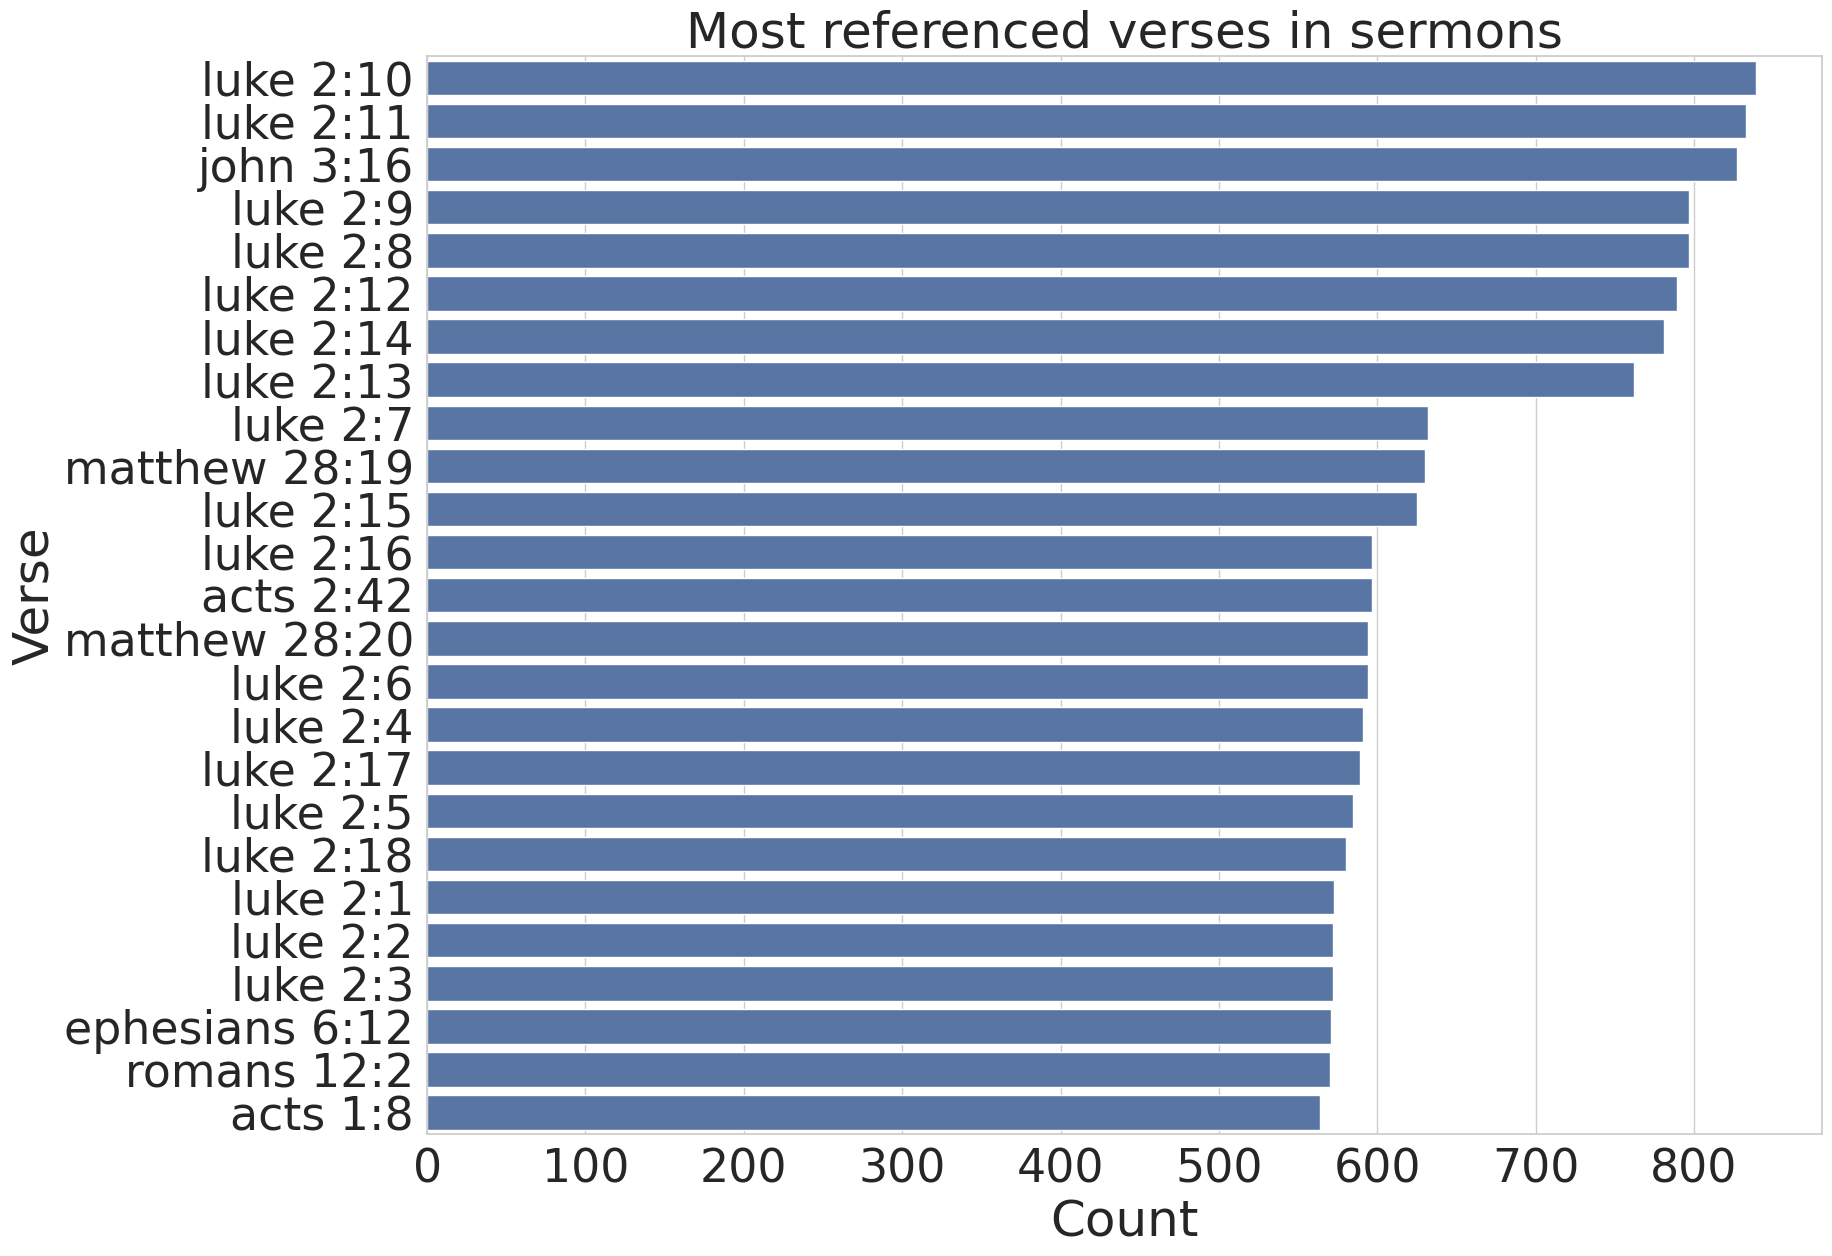

In [ ]:
# plot verse counts
sermon_verse_counts_limited = sermon_verse_counts.sort_values(by='count', ascending=False).head(25)

plt.figure(figsize=(18, 14))
plt.title("Most referenced verses in sermons")
sns.barplot(data=sermon_verse_counts_limited, y='verse', x='count')
plt.xlabel("Count")
plt.ylabel("Verse")
plt.show()

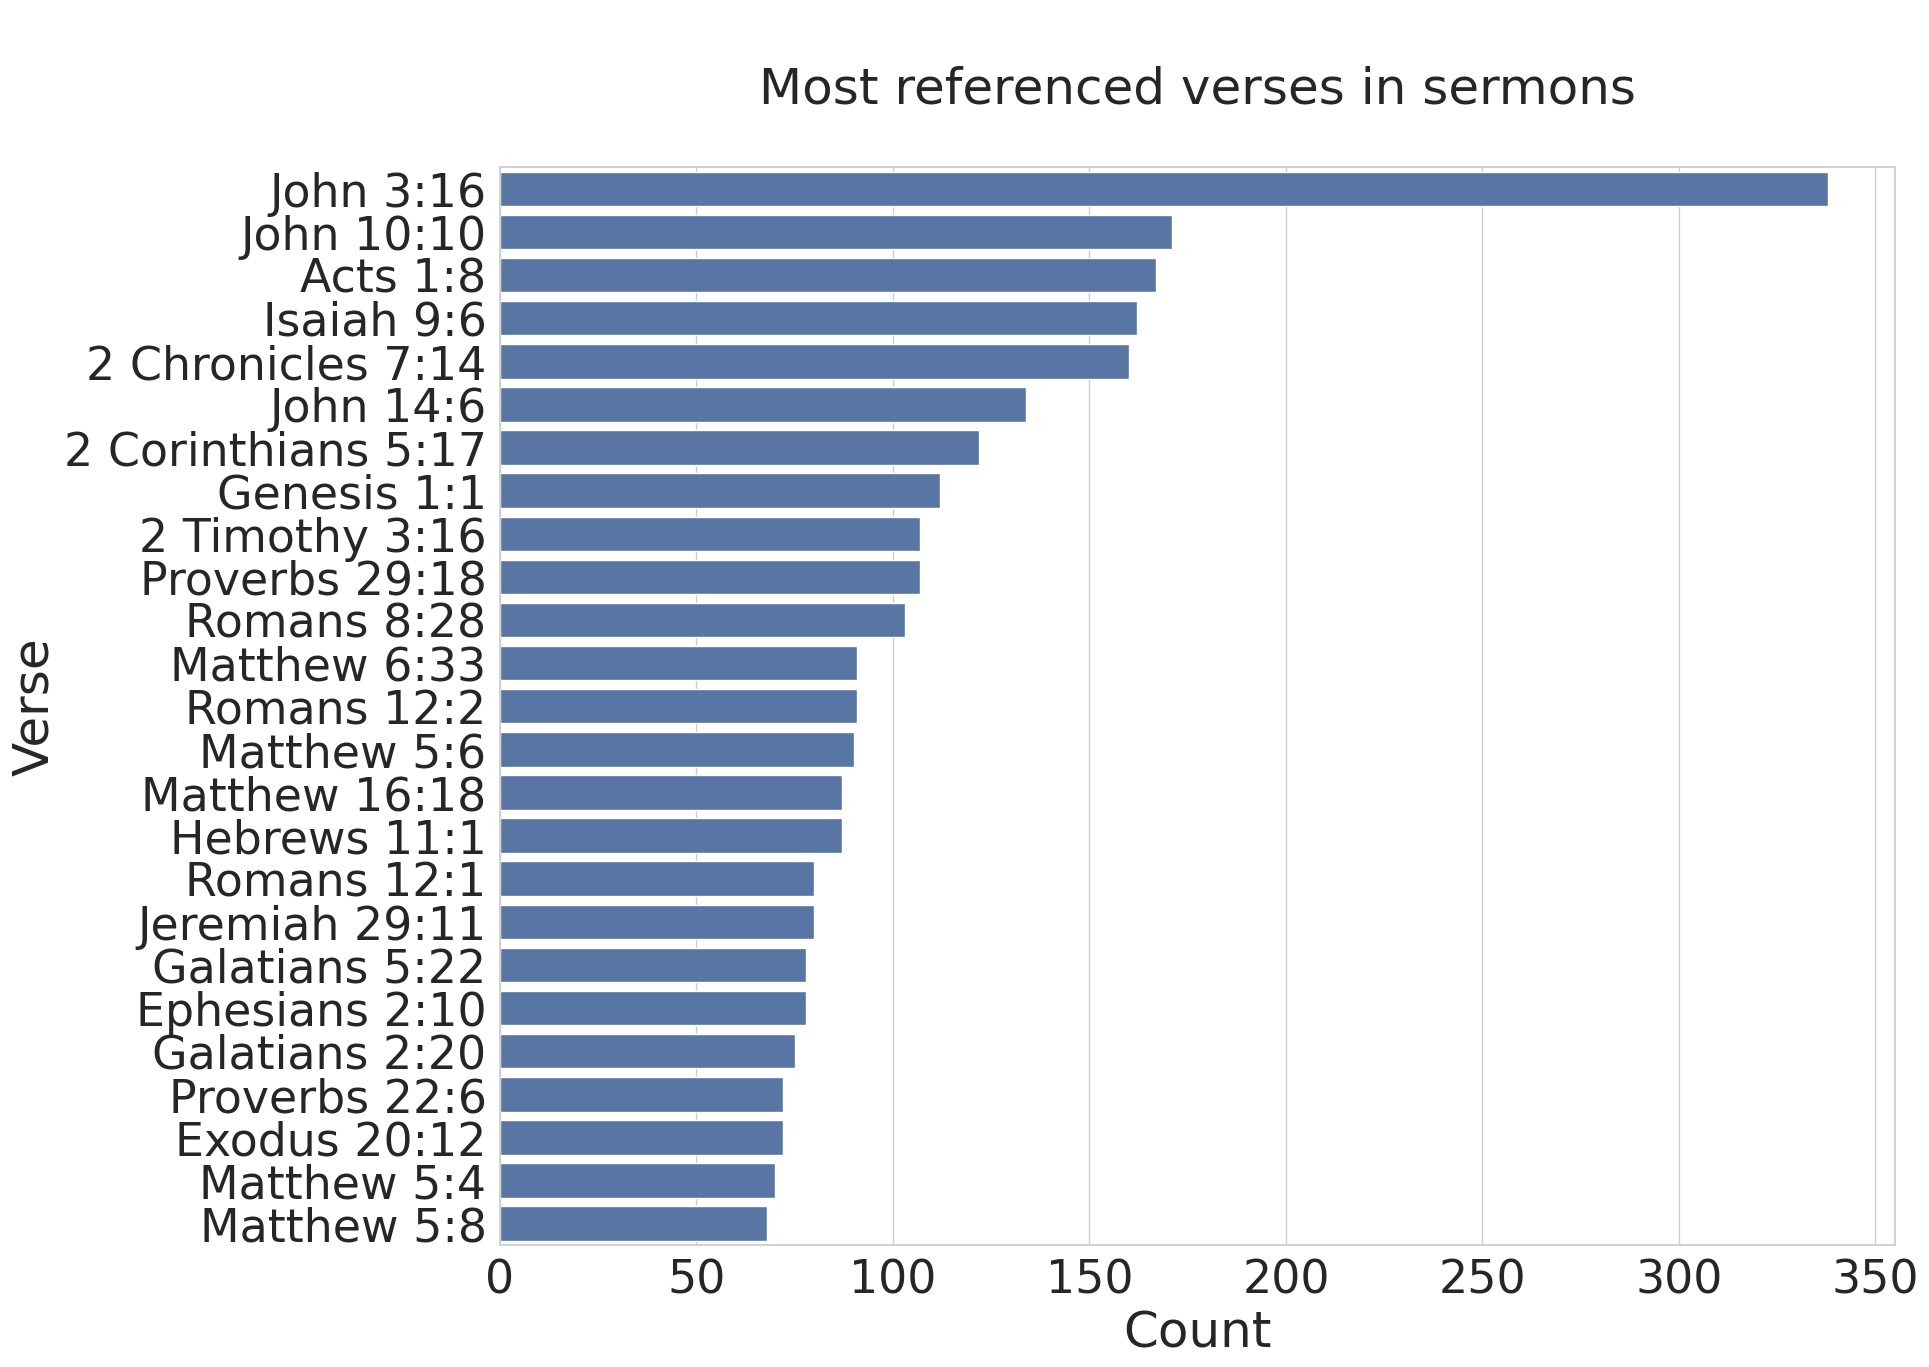

In [ ]:
# plot verse counts

sermon_verse_counts_limited_nr = sermon_verse_counts_no_ranges.sort_values(by='count', ascending=False).head(25)
sermon_verse_counts_limited_nr['verse'] = sermon_verse_counts_limited_nr['verse'].apply(capitalize_first_letter)

plt.figure(figsize=(18, 14))
plt.title("\nMost referenced verses in sermons\n")
sns.barplot(data=sermon_verse_counts_limited_nr, y='verse', x='count')
plt.xlabel("Count")
plt.ylabel("Verse")
plt.show()

# make nice tree plot of speakers

In [ ]:
merged.columns

Index(['llm_response', 'label_llm', 'verse_llm', 'congress_idx', 'text_x',
       'most_similar_verse', 'shared_ngrams', 'verse_baseline',
       'cosine_similarity', 'speech_id', 'bio_id', 'congress_num', 'year',
       'date', 'chamber', 'speaker', 'text_y', 'month_code', 'month', 'party',
       'state', 'gender', 'count'],
      dtype='object')

In [ ]:
merged['count'] = 1
speaker_agg = merged.groupby('bio_id').agg({'count': 'sum', 'party': 'first', 'state': 'first', 
                                            'speaker': 'first', 'year': ['min', 'max']})
speaker_agg['speaker'] = speaker_agg['speaker']
speaker_agg = speaker_agg.drop(columns=['speaker'])
speaker_agg.reset_index(inplace=True)

In [ ]:
import json

path = '/data/laviniad/congress_bioguides.jsonlist'
obj_list = {}

with open(path, 'r') as f:
    for l in f.readlines():
        obj = json.loads(l.strip())
        # get most recent term
        year_died = None
        if "deathDate" in obj.keys():
            year_died = obj["deathDate"]
        if (year_died == None) or (year_died == "") or (not (int(year_died[:4]) < 1995)): # hasn't died before 1995
            party = obj["party"]
            most_recent = obj['jobPositions'][-1] # resulting obj has "job" field and "congressAffiliation" field, which itself has "congress" and "partyAffiliation" and "represents"
            if "represents" in most_recent["congressAffiliation"].keys():
                state = most_recent["congressAffiliation"]["represents"]["regionCode"]
            else:
                print(most_recent["congressAffiliation"])
                state = "unlabeled"
            chamber = most_recent["job"]["name"]
            full_name = obj["givenName"] + " " + obj["familyName"]

            most_recent = most_recent["congressAffiliation"]["congress"]
            most_early = obj["jobPositions"][0]["congressAffiliation"]["congress"]

            if "startDate" in most_early.keys():
                if "endDate" in most_recent.keys():
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + most_recent["endDate"][:4] + ")"
                else:
                    time_in_congress = "(" + most_early["startDate"][:4] + "-" + "2024" + ")"
            else:
                print("***")
                time_in_congress = "(unlabeled)"

            obj_list[obj["usCongressBioId"]] = {"full_name": full_name, "party": party, "state": state, "chamber": chamber, "time_in_congress": time_in_congress}

{'congress': {'name': 'The 105th United States Congress', 'congressNumber': 105, 'congressType': 'USCongress', 'startDate': '1997-01-03', 'endDate': '1999-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'congressNumber': 118, 'congressType': 'USCongress', 'name': 'The 118th United States Congress', 'startDate': '2023-01-03'}, 'partyAffiliation': [{'party': {'name': 'Republican'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 101st United States Congress', 'congressNumber': 101, 'congressType': 'USCongress', 'startDate': '1989-01-03', 'endDate': '1991-01-03'}, 'partyAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}], 'caucusAffiliation': [{'party': {'name': 'Democrat'}, 'startCirca': False, 'endCirca': False}]}
{'congress': {'name': 'The 103rd United States Con

In [ ]:
speaker_agg['full_name'] = speaker_agg['bio_id'].progress_apply(lambda x: obj_list.get(x, {"full_name": "unknown"})["full_name"])
speaker_agg['time_in_congress'] = speaker_agg['bio_id'].progress_apply(lambda x: obj_list.get(x, {"time_in_congress": "unknown"})["time_in_congress"])

def get_min_and_max(time_in_congress):
    return [int(e) for e in time_in_congress[1:-1].split("-")]

speaker_agg['year_min'] = speaker_agg['time_in_congress'].apply(lambda x: get_min_and_max(x)[0])
speaker_agg['year_max'] = speaker_agg['time_in_congress'].apply(lambda x: get_min_and_max(x)[1])

100%|██████████| 354/354 [00:00<00:00, 279936.58it/s]


In [ ]:
def load_bioguide_id_to_dw_nominate(path='/data/laviniad/congress_errata/HSall_members.csv', first_year=1980):
    data = pd.read_csv(path)
    return {row['bioguide_id']: [row['nominate_dim1'], row['nominate_dim2']] for idx, row in data.iterrows()}

bioguide_id_to_dw_nom = load_bioguide_id_to_dw_nominate()
def get_actual_dw_nom(bio_id):
    return bioguide_id_to_dw_nom[bio_id][0]

speaker_agg['actual_dw_nom'] = speaker_agg['bio_id'].progress_apply(get_actual_dw_nom)

100%|██████████| 354/354 [00:00<00:00, 740171.29it/s]


In [ ]:
!pip install squarify

In [ ]:
def get_rep_string(row):
    out = row['state']['first'] + "\n(" + str(int(row['year_min'])).strip() + "-" + str(int(row['year_max'])).strip() + ")"
    print(out)
    return out

speaker_agg['rep_string'] = speaker_agg.progress_apply(get_rep_string, axis=1)
speaker_agg['count'] = speaker_agg['count']['sum']
speaker_agg['val'] = speaker_agg['count']['sum']
speaker_agg['p'] = speaker_agg['party']['first']

state_region = {'WV': 'South', 'TX': 'South', 'MO': 'South', 'MD': 'South', 'OK': 'South', 'GA': 'South', 'VA': 'South', 
                'CO': 'West', 'CA': 'West', 'NY': 'Northeast', 'FL': 'South', 'PA': 'Northeast', 'MI': 'Midwest',
                'UT': 'West', 'KS': 'Midwest', 'NC': 'South', 'OH': 'Midwest', 'IL': 'Midwest', 'MN': 'Midwest',
                'AL': 'South', 'TN': 'South', 'LA': 'South', 'IN': 'Midwest', 'WI': 'Midwest', 'IA': 'Midwest',
                'MS': 'South', 'KY': 'South', 'NE': 'Midwest', 'WA': 'West', 'SC': 'South', 'NJ': 'Northeast', 'OR': 'West',}

top20_speakers = speaker_agg.loc[:, ["rep_string", "full_name", "p", "val", 'actual_dw_nom', 'state', 'party']].sort_values( 
    by="val", ascending=False)[:20]

  0%|          | 0/354 [00:00<?, ?it/s]/tmp/ipykernel_3001961/2098940440.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  out = row['state']['first'] + "\n(" + str(int(row['year_min'])).strip() + "-" + str(int(row['year_max'])).strip() + ")"
100%|██████████| 354/354 [00:00<00:00, 2517.08it/s]

AL
(1997-2024)
HI
(2007-1991)
VA
(1991-2007)
MO
(1995-2001)
TN
(2003-2024)
GA
(2015-2024)
TX
(2019-2024)
AL
(2009-1997)
NE
(1991-2001)
MD
(1993-2013)
MT
(1977-2015)
CA
(1999-2015)
CA
(1983-2013)
AR
(2003-2001)
DE
(1973-2023)
GA
(1993-2024)
MO
(1997-2023)
OH
(1997-2017)
CA
(1983-2017)
OK
(2021-2024)
TX
(1997-2023)
LA
(1971-2005)
CO
(2021-2024)
FL
(1993-2017)
OH
(2001-2024)
KS
(1995-1999)
AR
(1975-1999)
MT
(1999-1991)
IN
(1983-2013)
WV
(1953-2011)
WI
(1999-2024)
IN
(2009-2003)
AL
(2003-2009)
GU
(2003-2019)
MN
(2007-2015)
KS
(2007-2009)
WY
(2007-2024)
GA
(2011-2011)
CO
(2009-2024)
TN
(2011-2019)
AL
(2011-2023)
KY
(2013-2024)
NJ
(2013-2024)
AL
(2017-2024)
TX
(2015-2024)
MI
(2015-2019)
IL
(2015-2024)
NE
(2017-2024)
IN
(2017-2024)
MI
(2017-2024)
AZ
(2017-2024)
NC
(2017-2024)
UT
(1997-2009)
MD
(1995-2024)
DE
(1989-2024)
IN
(2003-1999)
OH
(2019-2023)
ID
(1995-2001)
NC
(1991-2003)
SC
(2019-2024)
OK
(1995-2015)
GA
(1993-2005)
MI
(1977-2005)
ID
(1993-2024)
MD
(2017-2024)
CA
(1997-2007)
CA
(1997-2

In [ ]:
speaker_agg.to_csv('/data/laviniad/sermons-ir/temp_speaker_agg.csv')

In [ ]:
import pandas as pd
speaker_agg = pd.read_csv('/data/laviniad/sermons-ir/temp_speaker_agg.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# make sure it works
# url for color scheme: https://coolors.co/2d3142-413c58-c14953-8093f1-edddd4

import pandas as pd 
import squarify 
import matplotlib.pyplot as plt 
  
palette = {'Democrat': 'blue', 'Republican': 'red', 'New Progressive': 'grey', 'Popular Democrat': 'grey', 'Independence Party (Minnesota)': 'grey', 'Anti-Jacksonian': 'grey', 'Independent': 'green', 'unknown': 'black', 'Democrat Farmer Labor': 'blue'}
sns.set(context="notebook", font_scale=3, rc={'figure.figsize':(18,14), 'font.weight': 'normal'}, style='whitegrid')

party_to_color = {'Democrat': '#8093F1', 'Republican': '#C14953'}

def make_full_string(row):
    return row['full_name'] + "\n" + row['rep_string']

def remove_small_val_name(row):
    if int(row['val']) < 5:
        return ""
    return row['full_plot_string']

top20_speakers['full_plot_string'] = top20_speakers.apply(make_full_string, axis=1)
top20_speakers['plot_string'] = top20_speakers.apply(remove_small_val_name, axis=1)

top20_speakers['color'] = top20_speakers['p'].apply(lambda x: party_to_color[x])
top20_speakers['region'] = top20_speakers['state']['first'].apply(lambda x: state_region[x])

/tmp/ipykernel_3001961/1796059316.py:17: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(row['val']) < 5:


In [ ]:
def hex_to_rgb(hex_code):
    """Convert hex code to RGB tuple."""
    hex_code = hex_code.lstrip('#')  # Remove '#' if present
    return tuple(int(hex_code[i:i + 2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """Convert RGB tuple to hex code."""
    return '#{:02x}{:02x}{:02x}'.format(*rgb)


def adjust_intensity(hex_code, scale_factor):
    """Adjust the intensity of the color based on the input hex code and scale factor."""
    rgb = hex_to_rgb(hex_code)

    # Scale the RGB values based on the scaling factor
    adjusted_rgb = tuple(min(int(c * scale_factor), 255) for c in rgb)
    
    # Ensure the adjusted color remains within the RGB range
    adjusted_rgb = tuple(max(0, c) for c in adjusted_rgb)  # Ensure no component goes below 0

    return rgb_to_hex(adjusted_rgb)

def correct_color_for_dw(row, scale=0.3):
    color = row['color'].values[0]
    dw_nom = 1 + (row['actual_dw_nom'].values[0] * scale)
    color = str(color).lstrip('#')  # Convert to string and strip '#'
    
    hex_code = adjust_intensity(color, dw_nom)
    
    return hex_code

top20_speakers['color'] = top20_speakers.apply(correct_color_for_dw, axis=1)
print(top20_speakers)

          rep_string           full_name           p val actual_dw_nom state  \
                                                                       first   
29   WV\n(1953-2011)         Robert Byrd    Democrat  94        -0.309    WV   
134  TX\n(2005-2023)       Louie Gohmert  Republican  81         0.644    TX   
170  TX\n(1995-2024)  Sheila Jackson Lee    Democrat  45        -0.459    TX   
290  OK\n(2015-2019)       Steve Russell  Republican  44         0.473    OK   
325  MS\n(1993-2024)     Bennie Thompson    Democrat  31        -0.517    MS   
15   GA\n(1993-2024)      Sanford Bishop    Democrat  27        -0.285    GA   
106  MO\n(1981-1997)     Norvell Emerson  Republican  26         0.332    MO   
339  VA\n(1977-2009)         John Warner  Republican  23         0.262    VA   
61   GA\n(1993-2005)     Michael Collins  Republican  23         0.536    GA   
166  OK\n(1987-2023)        James Inhofe  Republican  22         0.552    OK   
85   IL\n(1997-2024)         Danny Davis

/tmp/ipykernel_3001961/3784150582.py:13: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  rect.set_hatch(hatch_region[top20_speakers['region'].iloc[i]])


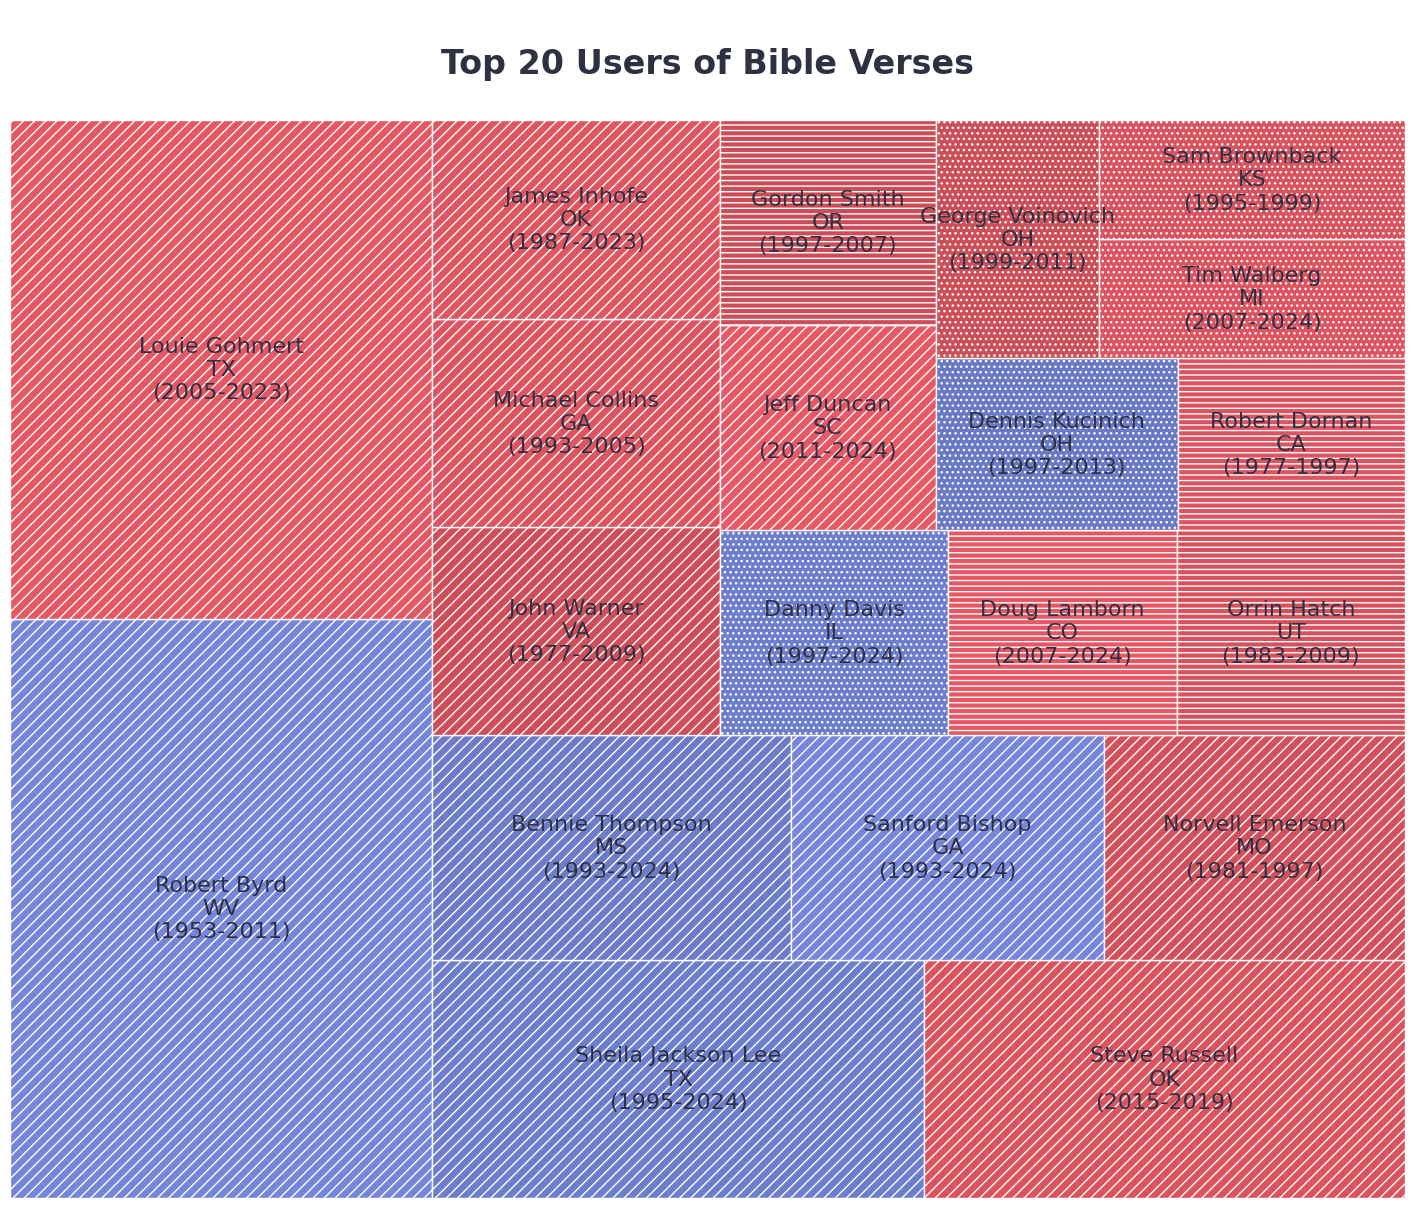

In [ ]:
plt.axis("off")
axis = squarify.plot(sizes=top20_speakers['val'], 
                     label=top20_speakers['plot_string'],
                     color=top20_speakers['color'],
                     pad=False, 
                     text_kwargs={'fontsize': 16, 'color': '#2D3142'},
                     #edgecolor='grey',  # Set border color
                     #linewidth=2
                     )  # Set border width
hatch_region = {'South': '/ / /', 'West': '- - -', 'Northeast': 'x x x', 'Midwest': '. . .'}
for i,rect in enumerate(axis.patches):
    # Set a different hatch for each bar
    rect.set_hatch(hatch_region[top20_speakers['region'].iloc[i]])

axis.set_title("\nTop 20 Users of Bible Verses\n", fontsize=24, color="#2D3142", weight='bold')
plt.show()

In [ ]:
top20_speakers.reset_index(drop=True, inplace=True)

In [ ]:
# make column names the first element in the tuple
top20_speakers.columns = [col[0] for col in top20_speakers.columns]

In [ ]:
top20_speakers

rep_string           full_name           p  val  actual_dw_nom state  \
0   WV\n(1953-2011)         Robert Byrd    Democrat   94         -0.309    WV   
1   TX\n(2005-2023)       Louie Gohmert  Republican   81          0.644    TX   
2   TX\n(1995-2024)  Sheila Jackson Lee    Democrat   45         -0.459    TX   
3   OK\n(2015-2019)       Steve Russell  Republican   44          0.473    OK   
4   MS\n(1993-2024)     Bennie Thompson    Democrat   31         -0.517    MS   
5   GA\n(1993-2024)      Sanford Bishop    Democrat   27         -0.285    GA   
6   MO\n(1981-1997)     Norvell Emerson  Republican   26          0.332    MO   
7   VA\n(1977-2009)         John Warner  Republican   23          0.262    VA   
8   GA\n(1993-2005)     Michael Collins  Republican   23          0.536    GA   
9   OK\n(1987-2023)        James Inhofe  Republican   22          0.552    OK   
10  IL\n(1997-2024)         Danny Davis    Democrat   18         -0.486    IL   
11  CO\n(2007-2024)        Doug Lamborn  Republican   18          0.667    CO   
12  UT\n(1983-2009)         Orrin Hatch  Republican   18          0.382    UT   
13  SC\n(2011-2024)         Jeff Duncan  Republican   17          0.702    SC   
14  OR\n(1997-2007)        Gordon Smith  Republican   17          0.192    OR   
15  OH\n(1997-2013)     Dennis Kucinich    Democrat   16         -0.582    OH   
16  CA\n(1977-1997)       Robert Dornan  Republican   15          0.490    CA   
17  OH\n(1999-2011)    George Voinovich  Republican   15          0.239    OH   
18  MI\n(2007-2024)         Tim Walberg  Republican   14          0.501    MI   
19  KS\n(1995-1999)       Sam Brownback  Republican   14          0.439    KS   

         party                     full_plot_string  \
0     Democrat         Robert Byrd\nWV\n(1953-2011)   
1   Republican       Louie Gohmert\nTX\n(2005-2023)   
2     Democrat  Sheila Jackson Lee\nTX\n(1995-2024)   
3   Republican       Steve Russell\nOK\n(2015-2019)   
4     Democrat     Bennie Thompson\nMS\n(1993-2024)   
5     Democrat      Sanford Bishop\nGA\n(1993-2024)   
6   Republican     Norvell Emerson\nMO\n(1981-1997)   
7   Republican         John Warner\nVA\n(1977-2009)   
8   Republican     Michael Collins\nGA\n(1993-2005)   
9   Republican        James Inhofe\nOK\n(1987-2023)   
10    Democrat         Danny Davis\nIL\n(1997-2024)   
11  Republican        Doug Lamborn\nCO\n(2007-2024)   
12  Republican         Orrin Hatch\nUT\n(1983-2009)   
13  Republican         Jeff Duncan\nSC\n(2011-2024)   
14  Republican        Gordon Smith\nOR\n(1997-2007)   
15    Democrat     Dennis Kucinich\nOH\n(1997-2013)   
16  Republican       Robert Dornan\nCA\n(1977-1997)   
17  Republican    George Voinovich\nOH\n(1999-2011)   
18  Republican         Tim Walberg\nMI\n(2007-2024)   
19  Republican       Sam Brownback\nKS\n(1995-1999)   

                            plot_string    color   region  
0          Robert Byrd\nWV\n(1953-2011)  #7485da    South  
1        Louie Gohmert\nTX\n(2005-2023)  #e65763    South  
2   Sheila Jackson Lee\nTX\n(1995-2024)  #6e7ecf    South  
3        Steve Russell\nOK\n(2015-2019)  #dc535e    South  
4      Bennie Thompson\nMS\n(1993-2024)  #6c7ccb    South  
5       Sanford Bishop\nGA\n(1993-2024)  #7586dc    South  
6      Norvell Emerson\nMO\n(1981-1997)  #d4505b    South  
7          John Warner\nVA\n(1977-2009)  #d04e59    South  
8      Michael Collins\nGA\n(1993-2005)  #e05460    South  
9         James Inhofe\nOK\n(1987-2023)  #e05560    South  
10         Danny Davis\nIL\n(1997-2024)  #6d7dcd  Midwest  
11        Doug Lamborn\nCO\n(2007-2024)  #e75763     West  
12         Orrin Hatch\nUT\n(1983-2009)  #d7515c     West  
13         Jeff Duncan\nSC\n(2011-2024)  #e95864    South  
14        Gordon Smith\nOR\n(1997-2007)  #cc4d57     West  
15     Dennis Kucinich\nOH\n(1997-2013)  #6979c6  Midwest  
16       Robert Dornan\nCA\n(1977-1997)  #dd535f     West  
17    George Voinovich\nOH\n(1999-2011)  #ce4e58  Midwest  
18         

rep_string                       WV\n(1953-2011)
full_name                            Robert Byrd
p                                       Democrat
val                                           94
actual_dw_nom                             -0.309
state                                         WV
party                                   Democrat
full_plot_string    Robert Byrd\nWV\n(1953-2011)
plot_string         Robert Byrd\nWV\n(1953-2011)
color                                    #7485da
region                                     South
Name: 0, dtype: object
Robert Byrd, WV (1953-2011)
rep_string                         TX\n(2005-2023)
full_name                            Louie Gohmert
p                                       Republican
val                                             81
actual_dw_nom                                0.644
state                                           TX
party                                   Republican
full_plot_string    Louie Gohmert\nTX\n(2005-2023)
pl

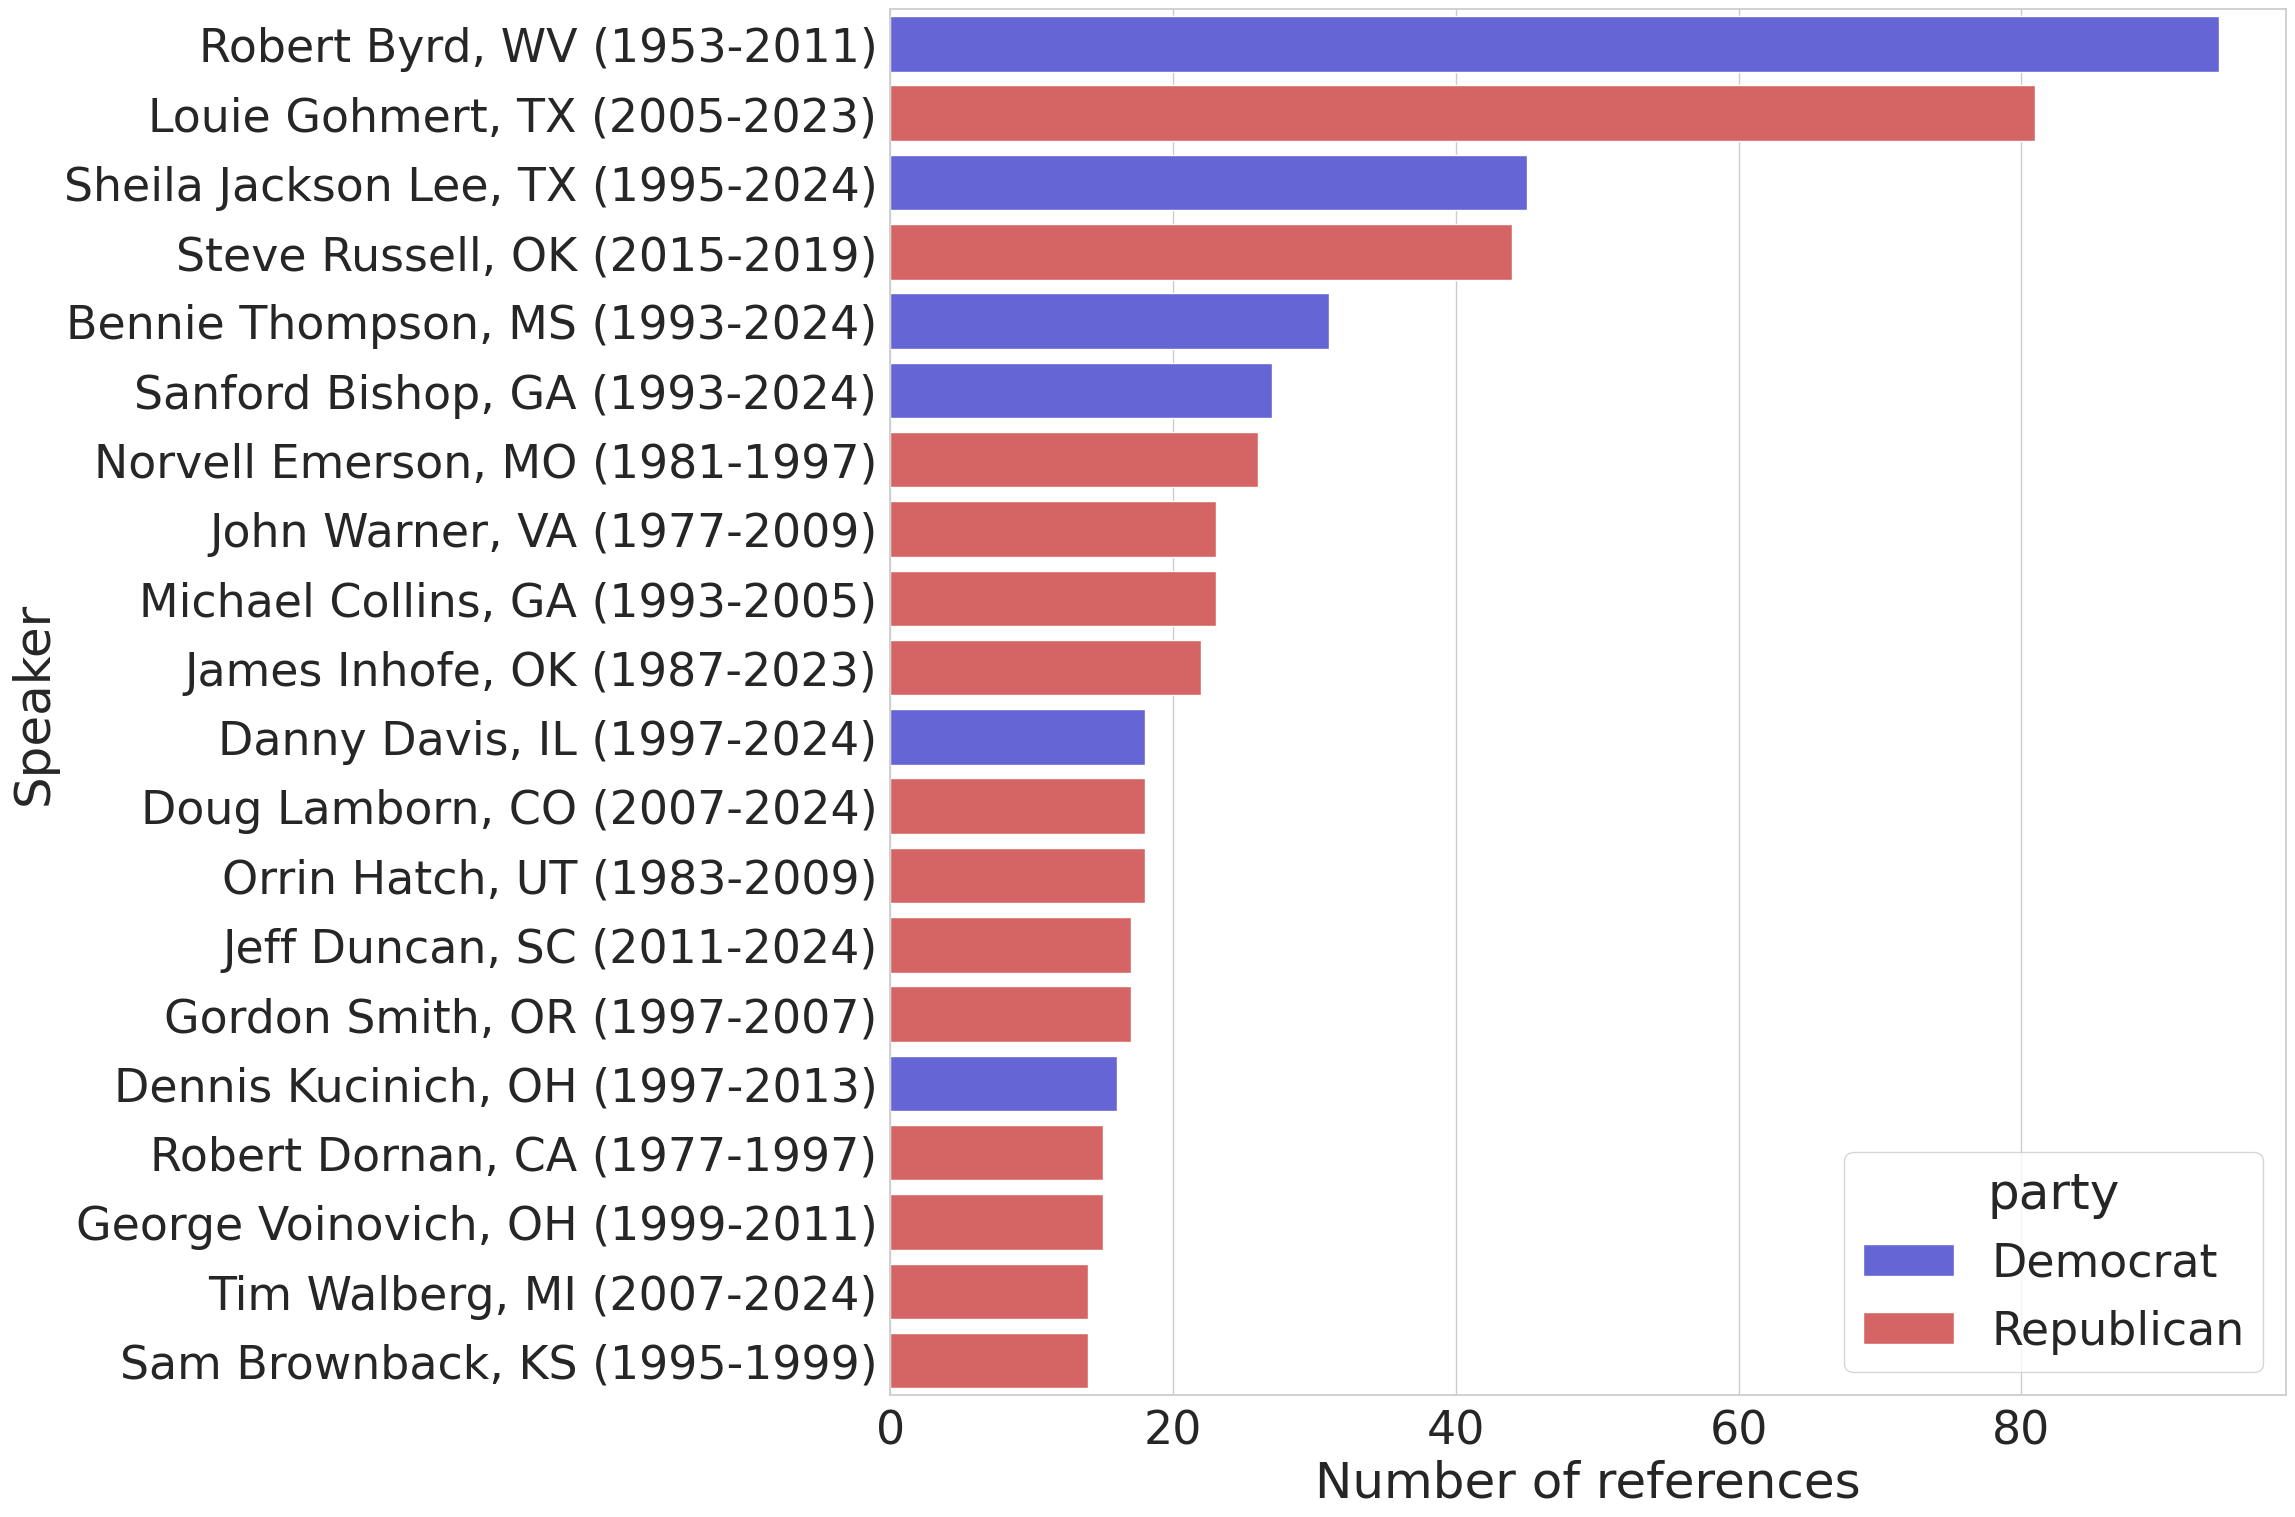

In [ ]:
# instead, make barplot of above results

def make_full_string(row):
    print(row)
    string_fixed = row['full_name'] + ", " + str(row['rep_string']).replace("\n", " ").replace("\\n", " ")
    print(string_fixed)
    return string_fixed

palette = {'Democrat': '#5252E8', 'Republican': '#E85252'}

temp_20 = top20_speakers.sort_values(by='val', ascending=False).copy()
temp_20['full_plot_string'] = temp_20.apply(make_full_string, axis=1)
plt.figure(figsize=(18, 18))
barplot = sns.barplot(data=temp_20, x='val', y='full_plot_string', palette=palette, hue='party')

plt.ylabel("Speaker")
plt.xlabel("Number of references")
plt.savefig("/home/laviniad/projects/religion_in_congress/notebooks/plots/new_plots/top20_speakers.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()

In [ ]:
top20_speakers

rep_string           full_name           p  val  actual_dw_nom state  \
0   WV\n(1953-2011)         Robert Byrd    Democrat   94         -0.309    WV   
1   TX\n(2005-2023)       Louie Gohmert  Republican   81          0.644    TX   
2   TX\n(1995-2024)  Sheila Jackson Lee    Democrat   45         -0.459    TX   
3   OK\n(2015-2019)       Steve Russell  Republican   44          0.473    OK   
4   MS\n(1993-2024)     Bennie Thompson    Democrat   31         -0.517    MS   
5   GA\n(1993-2024)      Sanford Bishop    Democrat   27         -0.285    GA   
6   MO\n(1981-1997)     Norvell Emerson  Republican   26          0.332    MO   
7   VA\n(1977-2009)         John Warner  Republican   23          0.262    VA   
8   GA\n(1993-2005)     Michael Collins  Republican   23          0.536    GA   
9   OK\n(1987-2023)        James Inhofe  Republican   22          0.552    OK   
10  IL\n(1997-2024)         Danny Davis    Democrat   18         -0.486    IL   
11  CO\n(2007-2024)        Doug Lamborn  Republican   18          0.667    CO   
12  UT\n(1983-2009)         Orrin Hatch  Republican   18          0.382    UT   
13  SC\n(2011-2024)         Jeff Duncan  Republican   17          0.702    SC   
14  OR\n(1997-2007)        Gordon Smith  Republican   17          0.192    OR   
15  OH\n(1997-2013)     Dennis Kucinich    Democrat   16         -0.582    OH   
16  CA\n(1977-1997)       Robert Dornan  Republican   15          0.490    CA   
17  OH\n(1999-2011)    George Voinovich  Republican   15          0.239    OH   
18  MI\n(2007-2024)         Tim Walberg  Republican   14          0.501    MI   
19  KS\n(1995-1999)       Sam Brownback  Republican   14          0.439    KS   

         party                     full_plot_string  \
0     Democrat         Robert Byrd\nWV\n(1953-2011)   
1   Republican       Louie Gohmert\nTX\n(2005-2023)   
2     Democrat  Sheila Jackson Lee\nTX\n(1995-2024)   
3   Republican       Steve Russell\nOK\n(2015-2019)   
4     Democrat     Bennie Thompson\nMS\n(1993-2024)   
5     Democrat      Sanford Bishop\nGA\n(1993-2024)   
6   Republican     Norvell Emerson\nMO\n(1981-1997)   
7   Republican         John Warner\nVA\n(1977-2009)   
8   Republican     Michael Collins\nGA\n(1993-2005)   
9   Republican        James Inhofe\nOK\n(1987-2023)   
10    Democrat         Danny Davis\nIL\n(1997-2024)   
11  Republican        Doug Lamborn\nCO\n(2007-2024)   
12  Republican         Orrin Hatch\nUT\n(1983-2009)   
13  Republican         Jeff Duncan\nSC\n(2011-2024)   
14  Republican        Gordon Smith\nOR\n(1997-2007)   
15    Democrat     Dennis Kucinich\nOH\n(1997-2013)   
16  Republican       Robert Dornan\nCA\n(1977-1997)   
17  Republican    George Voinovich\nOH\n(1999-2011)   
18  Republican         Tim Walberg\nMI\n(2007-2024)   
19  Republican       Sam Brownback\nKS\n(1995-1999)   

                            plot_string    color   region  
0          Robert Byrd\nWV\n(1953-2011)  #7485da    South  
1        Louie Gohmert\nTX\n(2005-2023)  #e65763    South  
2   Sheila Jackson Lee\nTX\n(1995-2024)  #6e7ecf    South  
3        Steve Russell\nOK\n(2015-2019)  #dc535e    South  
4      Bennie Thompson\nMS\n(1993-2024)  #6c7ccb    South  
5       Sanford Bishop\nGA\n(1993-2024)  #7586dc    South  
6      Norvell Emerson\nMO\n(1981-1997)  #d4505b    South  
7          John Warner\nVA\n(1977-2009)  #d04e59    South  
8      Michael Collins\nGA\n(1993-2005)  #e05460    South  
9         James Inhofe\nOK\n(1987-2023)  #e05560    South  
10         Danny Davis\nIL\n(1997-2024)  #6d7dcd  Midwest  
11        Doug Lamborn\nCO\n(2007-2024)  #e75763     West  
12         Orrin Hatch\nUT\n(1983-2009)  #d7515c     West  
13         Jeff Duncan\nSC\n(2011-2024)  #e95864    South  
14        Gordon Smith\nOR\n(1997-2007)  #cc4d57     West  
15     Dennis Kucinich\nOH\n(1997-2013)  #6979c6  Midwest  
16       Robert Dornan\nCA\n(1977-1997)  #dd535f     West  
17    George Voinovich\nOH\n(1999-2011)  #ce4e58  Midwest  
18         

/tmp/ipykernel_3001961/1242696016.py:76: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  bar.set_hatch(hatch)
/tmp/ipykernel_3001961/1242696016.py:80: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error in 3.11.
  mpatches.Patch(facecolor='none', edgecolor='black', hatch=h, label=region)


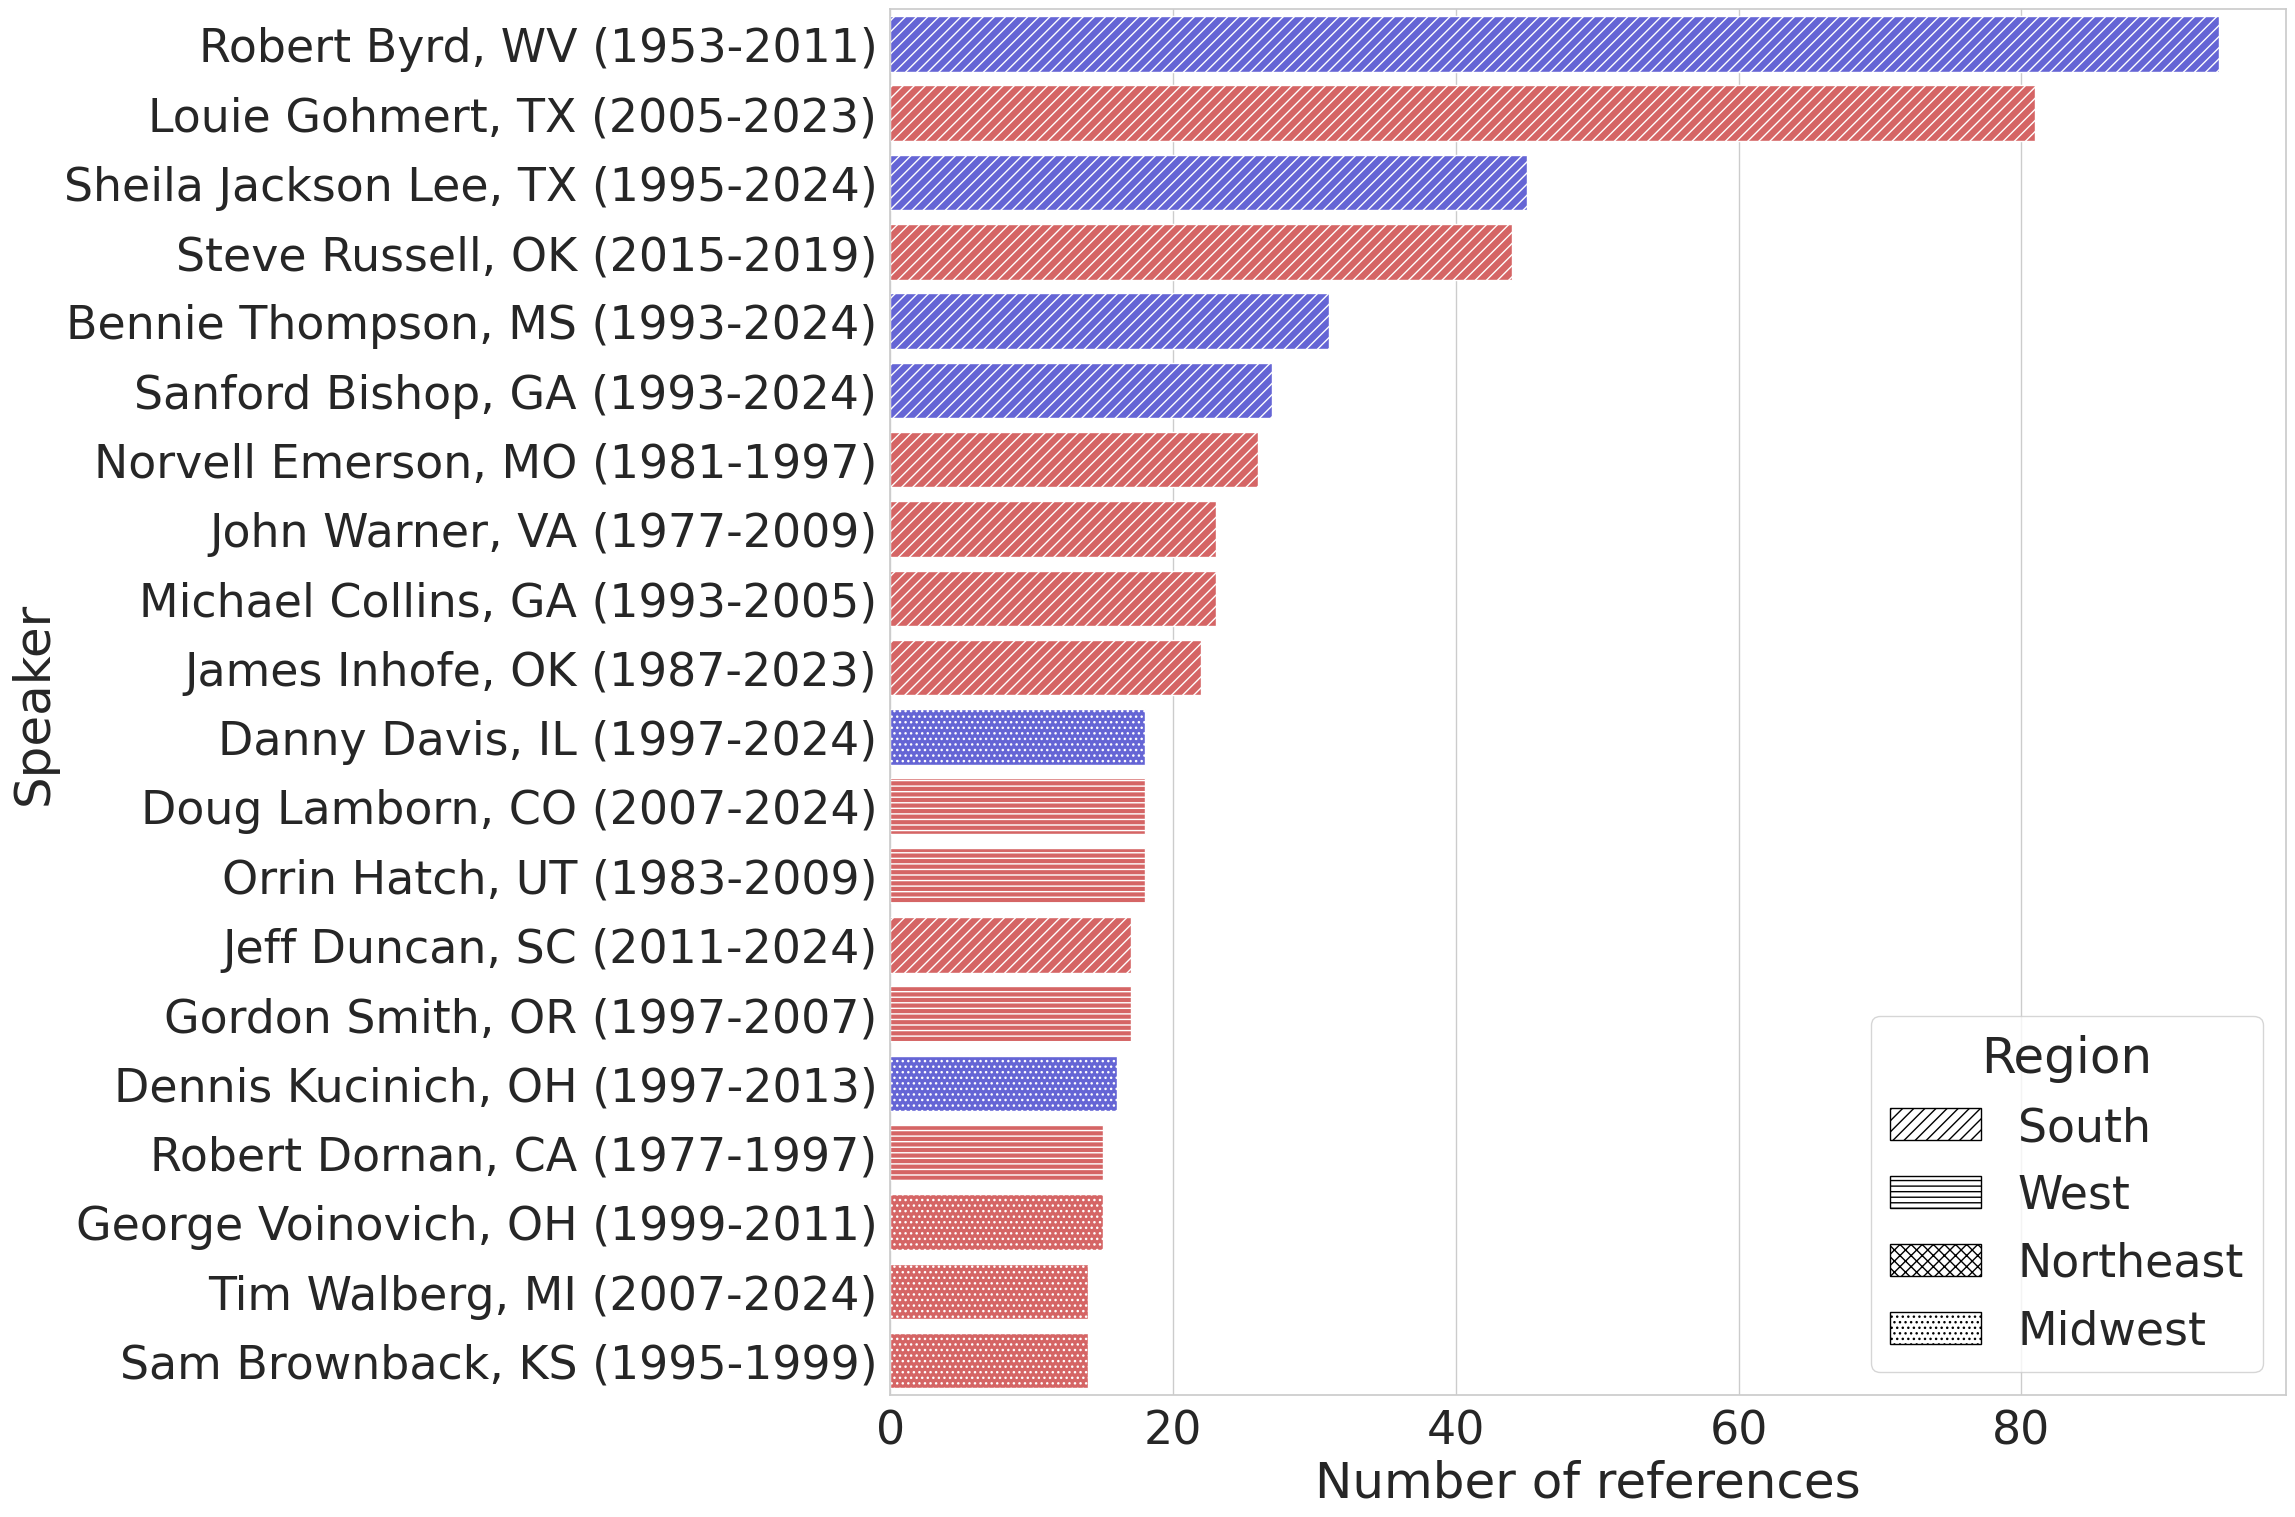

In [ ]:
import matplotlib.patches as mpatches

def make_full_string(row):
    # Extract 'full_name' and 'rep_string' values from the row
    full_name = row['full_name']
    rep_string = row['rep_string']
    
    # Ensure they're properly converted to strings and formatted
    full_name_str = str(full_name)
    rep_string_str = str(rep_string).replace("\n", " ").replace("\\n", " ")
    
    # Combine into the desired string
    string_fixed = f"{full_name_str}, {rep_string_str}"
    return string_fixed

palette = {'Democrat': '#5252E8', 'Republican': '#E85252'}
hatch_region = {'South': '/ / /', 'West': '- - -', 'Northeast': 'x x x', 'Midwest': '. . .'}

temp_20 = top20_speakers.sort_values(by='val', ascending=False).copy().reset_index()
temp_20['full_plot_string'] = temp_20.apply(make_full_string, axis=1)
temp_20['p'] = temp_20['p'].astype('category')  # Ensure party is categorical
temp_20 = temp_20.reset_index()

temp_20.columns = [col[0] if isinstance(col, tuple) else col for col in temp_20.columns]
temp_20['region_hatch'] = temp_20['region'].apply(lambda x: hatch_region[x])

temp_20 = temp_20.dropna(subset=['val', 'full_plot_string', 'p'])  # Drop rows with missing values
temp_20['full_plot_string'] = temp_20['full_plot_string'].astype(str)


import matplotlib.patches as mpatches

# Plot
plt.figure(figsize=(18, 18))
palette = {'Democrat': '#5252E8', 'Republican': '#E85252'}
hatch_region = {'South': '/ / /', 'West': '- - -', 'Northeast': 'x x x', 'Midwest': '. . .'}

barplot = sns.barplot(
    data=temp_20,
    x='val',
    y='full_plot_string',
    palette=palette,
    hue='p',
    order=None,
    hue_order=['Democrat', 'Republican']
)

# Get list of bar patches that are actual bars (not legends)
bars = [bar for bar in barplot.patches if bar.get_width() > 0]

# Build a lookup of bar y-coordinates and hue colors to actual data
bar_data_lookup = {
    row['full_plot_string']: hatch_region[row['region']]
    for _, row in temp_20.iterrows()
}

# Get hue color to party name mapping
color_to_party = {v: k for k, v in palette.items()}

# For each bar, get y-label and facecolor (which tells us the hue/party), then assign the correct hatch
for bar in bars:
    bar_y = bar.get_y() + bar.get_height() / 2
    label = barplot.axes.get_yticklabels()
    
    # Find the closest label to this bar's y center
    closest_label = min(label, key=lambda t: abs(t.get_position()[1] - bar_y))
    full_string = closest_label.get_text()

    # Figure out party based on facecolor
    facecolor = tuple(bar.get_facecolor())
    facecolor_rgb = tuple(int(255 * c) for c in facecolor[:3])  # convert to 0-255
    facecolor_hex = '#{:02x}{:02x}{:02x}'.format(*facecolor_rgb)

    # Use (label, party) to get the correct hatch
    hatch = bar_data_lookup.get(full_string, '')
    bar.set_hatch(hatch)


hatch_handles = [
    mpatches.Patch(facecolor='none', edgecolor='black', hatch=h, label=region)
    for region, h in hatch_region.items()
]

plt.legend(handles=hatch_handles, title='Region', loc='lower right')

plt.ylabel("Speaker")
plt.xlabel("Number of references")
plt.savefig("/home/laviniad/projects/religion_in_congress/plots/br_top20_speakers.pdf", bbox_inches='tight', format='pdf', dpi=300)
plt.show()


In [ ]:
print("Available keys in bar_data_lookup:")
for k in bar_data_lookup.keys():
    print(k)


Available keys in bar_data_lookup:
('Robert Byrd, WV (1953-2011)', 'Democrat')
('Louie Gohmert, TX (2005-2023)', 'Republican')
('Sheila Jackson Lee, TX (1995-2024)', 'Democrat')
('Steve Russell, OK (2015-2019)', 'Republican')
('Bennie Thompson, MS (1993-2024)', 'Democrat')
('Sanford Bishop, GA (1993-2024)', 'Democrat')
('Norvell Emerson, MO (1981-1997)', 'Republican')
('John Warner, VA (1977-2009)', 'Republican')
('Michael Collins, GA (1993-2005)', 'Republican')
('James Inhofe, OK (1987-2023)', 'Republican')
('Danny Davis, IL (1997-2024)', 'Democrat')
('Doug Lamborn, CO (2007-2024)', 'Republican')
('Orrin Hatch, UT (1983-2009)', 'Republican')
('Jeff Duncan, SC (2011-2024)', 'Republican')
('Gordon Smith, OR (1997-2007)', 'Republican')
('Dennis Kucinich, OH (1997-2013)', 'Democrat')
('Robert Dornan, CA (1977-1997)', 'Republican')
('George Voinovich, OH (1999-2011)', 'Republican')
('Tim Walberg, MI (2007-2024)', 'Republican')
('Sam Brownback, KS (1995-1999)', 'Republican')


In [ ]:
actual_bar_order = [
    (bar.get_y(), bar.get_height())  # optional info, can just number them
    for bar in barplot.patches
]
print("Actual bar order:")
for i, (y, height) in enumerate(actual_bar_order):
    print(f"Bar {i}: y = {y:.2f}, height = {height:.2f}")

Actual bar order:
Bar 0: y = -0.40, height = 0.80
Bar 1: y = 1.60, height = 0.80
Bar 2: y = 3.60, height = 0.80
Bar 3: y = 4.60, height = 0.80
Bar 4: y = 9.60, height = 0.80
Bar 5: y = 14.60, height = 0.80
Bar 6: y = 0.60, height = 0.80
Bar 7: y = 2.60, height = 0.80
Bar 8: y = 5.60, height = 0.80
Bar 9: y = 6.60, height = 0.80
Bar 10: y = 7.60, height = 0.80
Bar 11: y = 8.60, height = 0.80
Bar 12: y = 10.60, height = 0.80
Bar 13: y = 11.60, height = 0.80
Bar 14: y = 12.60, height = 0.80
Bar 15: y = 13.60, height = 0.80
Bar 16: y = 15.60, height = 0.80
Bar 17: y = 16.60, height = 0.80
Bar 18: y = 17.60, height = 0.80
Bar 19: y = 18.60, height = 0.80
Bar 20: y = 0.00, height = 0.00
Bar 21: y = 0.00, height = 0.00
